In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import numpy as np
import cosmolopy.distance as cd
from astropy.stats import median_absolute_deviation
%pylab inline

/software/local/lib64/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


In [2]:
sample = h5py.File("red_photometric_sample_v2ij_auto.h5" , "r")
lrg_dense = h5py.File("LRG_lmin_0.5_nbar_0.001_auto.h5" , "r")
lrg_lum = h5py.File("LRG_lmin_1.0_nbar_0.0002_auto.h5" , "r")

In [3]:
reduced_kids = h5py.File("reduced_kids_auto.h5" , "r")

ID_kids = reduced_kids['ID'][:28158450]
mi = reduced_kids['mi'][:28158450]
z_ann = reduced_kids['redshift'][:28158450]
colors = reduced_kids['colors'][:28158450]
color_errs = reduced_kids['color_errs'][:28158450]

In [4]:
z_bpz = reduced_kids['BPZ'][:28158450]
RA = reduced_kids['RA'][:28158450]
DEC = reduced_kids['DEC'][:28158450]

In [ ]:
plt.scatter(RA, DEC, s = 0.01)

In [5]:
spec_kids = h5py.File("reduced_speckids_auto.h5" , 'r')

In [6]:
def dflens():
    fname = 'KiDS_DR3_x_2dFLenS.txt'
    with open(fname) as f:
        
         lines = f.readlines()
            
    ID_2df , z_2df , mi_2df = [] , [] , []
    for i in range(1,len(lines)):
        
     if (lines[i].split()[:200][-26]!='""'):  
        ID_2df.append('KIDS '+lines[i].split()[:200][1].replace('"',''))
        z_2df.append(lines[i].split()[:200][-3])
        mi_2df.append(float(lines[i].split()[:200][-26]))
    #print z_2df
    #print mi_2df
    z_2df = np.array(z_2df ,dtype = float)
    ID_2df = np.array(ID_2df)
    mi_2df = np.array(mi_2df, dtype = float)
     
    return ID_2df , z_2df, mi_2df

ID_2df , z_2df , mi_2df  = dflens()

In [7]:
fname = 'KiDS_DR3_x_2dFLenS.txt'
with open(fname) as f:
        
         lines = f.readlines()
qual_2df = []            
for i in range(1,len(lines)):     
    if (lines[i].split()[:200][-26]!='""'):  

        qual_2df.append(lines[i].split()[:200][-2])
q_2df = np.array(qual_2df,dtype = float)
#sns.distplot(q_2df[mask] , kde=False)
#sns.distplot(q_2df , kde=False)

In [8]:
ID_2df , z_2df , mi_2df = ID_2df[q_2df==4] , z_2df[q_2df==4] , mi_2df[q_2df==4]
ID_2df , z_2df , mi_2df = ID_2df[z_2df<0.7] , z_2df[z_2df<0.7] , mi_2df[z_2df<0.7]

In [9]:
ID_spec = spec_kids["ID"][:]
z_spec = spec_kids["redshift"][:]
mi_spec = spec_kids["mi"][:]
RA_spec = spec_kids["RA"][:]
DEC_spec = spec_kids["DEC"][:]

mask = np.where(np.in1d(ID_2df , ID_spec)==False)[0]
ID_2df, z_2df, mi_2df = ID_2df[mask], z_2df[mask], mi_2df[mask]

In [10]:
colors_spec = spec_kids["colors"][:]

Text(0.5,0,u'$z$')

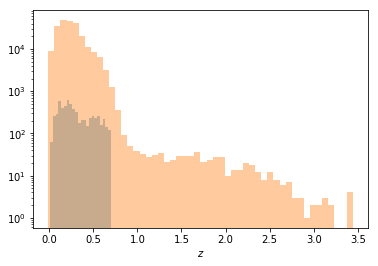

In [11]:
sns.distplot(z_2df , kde = False)
sns.distplot(z_spec , kde = False)
plt.yscale("log")
plt.xlabel("$z$")

In [12]:
ID_specall = np.hstack([ID_spec, ID_2df])
z_specall = np.hstack([z_spec, z_2df])
mi_specall = np.hstack([mi_spec, mi_2df])

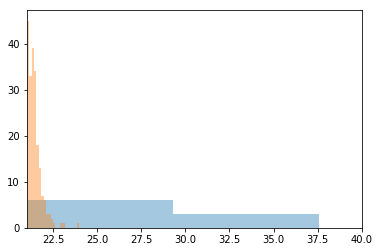

(0.5, 1.0)

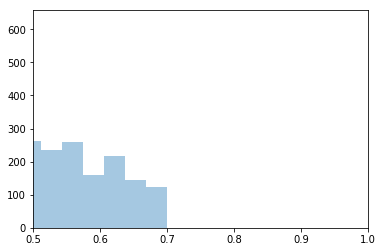

In [13]:
sns.distplot(mi_2df[mi_2df>21] , kde = False)
sns.distplot(mi_spec[mi_spec>21] , kde= False)
plt.xlim(21,40)
#plt.ylim(0,1000)
plt.show()
plt.close()
sns.distplot(z_2df , kde = False)
plt.xlim(0.5,1.0)

#plt.xlim(20.5,22)
#plt.ylim(0,1000)

In [14]:
z_dense = lrg_dense["redshift"][:]
ID_dense = lrg_dense["ID"][:]
mi_dense = lrg_dense["mi"][:]
colors_dense = lrg_dense["colors"][:]

z_lum = lrg_lum["redshift"][:]
ID_lum = lrg_lum["ID"][:]
mi_lum = lrg_lum["mi"][:]
colors_lum = lrg_lum["colors"][:]

['KIDS J000000.37-312726.61' 'KIDS J000000.42-325530.01'
 'KIDS J000000.81-325414.70' ... 'KIDS J235959.03-331531.90'
 'KIDS J235959.34-325618.19' 'KIDS J235959.67-333022.56']
[21.236362 21.340172 20.113409 ... 19.108353 19.360716 20.956203]


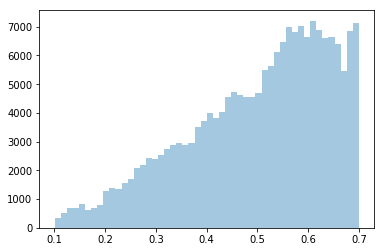

In [15]:
print ID_dense
print mi_dense
sns.distplot(z_dense , kde = False)
#sns.distplot(z_lum , kde = False)

In [16]:
def vc(z):
    '''
    dv/dz to impose uniformity
    in redshift
    '''
    cosmo = {'omega_M_0':0.3, 'omega_lambda_0':0.7, 'omega_k_0':0.0, 'h':1.0}

    return cd.comoving_volume(z,**cosmo)

In [17]:
def red_spec_dist_dense():
    
    lrg_spec_mask = np.where((np.in1d(ID_specall , ID_dense)==True)&(z_specall>0.1)&(z_specall<0.7))
    
    plt.figure(figsize=(10,10))
    
    sns.distplot(z_dense , kde = False , bins = 50 , hist_kws={"histtype": "step", "linewidth": 6, 
                                                               "alpha" : 1.0, "label":"all redmagic gals"})
    sns.distplot(z_specall[lrg_spec_mask], 
                 kde = False , bins =50,hist_kws={"histtype": "step", "linewidth": 6, 
                                                  "alpha" : 1.0, "label":"redmagic gals with specz"})
    
    ztest = np.linspace(0.1, 0.7 , 50)
    bins = .5*(ztest[1:]+ztest[:-1])
    dvbin = vc(ztest[1:]) - vc(ztest[:-1])
    dvbin = dvbin * 360.3 / (41252.96)
    nbar = 0.001
    plt.plot(bins , nbar * dvbin, lw = 4, label = "constant comoving density")
    plt.legend(loc="best" , fontsize = 15)
    plt.xlim((0.05,0.75))
    #plt.ylim((0.5,24000))
    plt.xlabel("$z_{red}$" , fontsize = 20)
    plt.ylabel("$dN/dz_{red}$" , fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)

    return None

def red_spec_dist_lum():
    
    lrg_spec_mask = np.where((np.in1d(ID_specall , ID_lum)==True)&(z_specall>0.1)&(z_specall<0.7))
    
    plt.figure(figsize=(10,10))
    
    sns.distplot(z_lum , kde = False , bins = 50 , hist_kws={"histtype": "step", "linewidth": 6, 
                                                               "alpha" : 1.0, "label":"all redmagic gals"})
    sns.distplot(z_specall[lrg_spec_mask], 
                 kde = False , bins =50,hist_kws={"histtype": "step", "linewidth": 6, 
                                                  "alpha" : 1.0, "label":"redmagic gals with specz"})
    
    ztest = np.linspace(0.1, 0.7 , 50)
    bins = .5*(ztest[1:]+ztest[:-1])
    dvbin = vc(ztest[1:]) - vc(ztest[:-1])
    dvbin = dvbin * 360.3 / (41252.96)
    nbar = 0.0002
    plt.plot(bins , nbar * dvbin, lw = 4, label = "constant comoving density")
    plt.legend(loc="best" , fontsize = 15)
    plt.xlim((0.05,0.75))
    #plt.ylim((0.5,4800))
    plt.xlabel("$z_{red}$" , fontsize = 20)
    plt.ylabel("$dN/dz_{red}$" , fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)

    return None

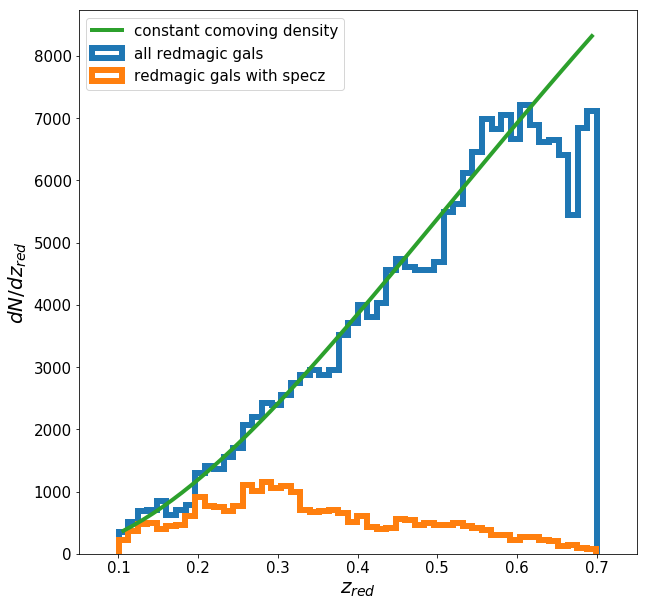

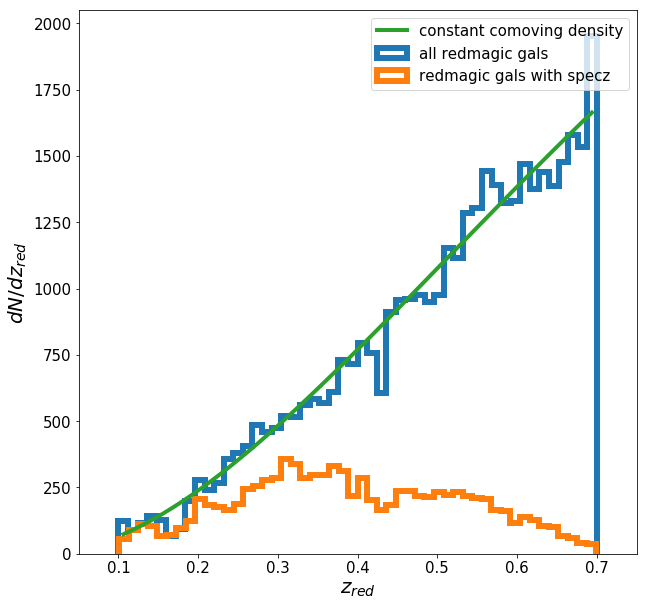

In [18]:
red_spec_dist_dense()
red_spec_dist_lum()

In [19]:
import corner
from matplotlib import lines as mlines
levels = [0.682689492137086,0.95449973610364]
def red_scatter_dense():
    
    mask_one = np.where((np.in1d(ID_dense , ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_dense[mask_one])==True))[0]
    
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    
    print ID_dense[mask_one][arg_one] 
    print ID_specall[mask_two][arg_two]
    #print RA[mask_one][arg_one]
    
    out_mask=np.abs(z_dense[mask_one][arg_one]-z_specall[mask_two][arg_two])/(1+z_specall[mask_two][arg_two])>0.07
    
    print "percentage outlier fraction" , np.where(out_mask==True)[0].shape[0]*1.0*100/out_mask.shape[0]


    
    plt.figure(figsize=(10,10))

    corner.hist2d(z_dense[mask_one][arg_one] , z_specall[mask_two][arg_two], color='#FF7F0E', plot_datapoints=False,
                  bins=50, levels=levels, fill_contours=True, smooth=0.5, label = "dense sample with spec-z")
    
    zp_all = z_dense[mask_one][arg_one]
    zs_all = z_specall[mask_two][arg_two]
    bins = np.linspace(0.1,0.7,40)
    for k in range(len(bins)-1):
        
        zp = zp_all[(zp_all>bins[k])&(zp_all<bins[k+1])] 
        zs = zs_all[(zp_all>bins[k])&(zp_all<bins[k+1])]
        ez = (zp - zs)
        x75, x25 = np.percentile(ez,[84,16.])
        sz = (x75 - x25)/2
        outlier_limit = 5.*sz
        mask = np.abs(zs-zp) > outlier_limit        
        plt.scatter(zp[mask], zs[mask], s = 2,c='#1F77B4')
    #plt.scatter(zp_all[out_mask] , zs_all[out_mask], c = "r")    
        
    thick_line1 = mlines.Line2D([], [], ls='-', c='#FF7F0E', linewidth=12, alpha=0.5, 
                                label="Dense sample with spec-z")
    thick_line2 = mlines.Line2D([], [], ls='-', c='#1F77B4', linewidth=12, alpha=0.5, 
                                label=r"$5\sigma \; \mathrm{outliers}$")
    plt.legend(loc='upper left', handles=[thick_line1, thick_line2], 
               frameon=False, fontsize=15, handletextpad=1.0, scatteryoffsets=[0.5])
    
    
    plt.xlim((0.01,0.79))
    plt.ylim((0.01,0.79))
    plt.xlabel("$z_{red}$" , fontsize = 20)
    plt.ylabel("$z_{spec}$" , fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    return None

def red_scatter_lum():
    
    mask_one = np.where((np.in1d(ID_lum, ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_lum[mask_one])==True))[0]
    
    arg_one = np.argsort(ID_lum[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    
    print z_lum[mask_one][arg_one].shape

    
    plt.figure(figsize=(10,10))

    
    out_mask =  np.abs(z_lum[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_specall[mask_two][arg_two])>0.14
    
    print "percentage outlier fraction" , np.where(out_mask==True)[0].shape[0]*1.0*100/out_mask.shape[0]
    
    zp_all = z_lum[mask_one][arg_one]
    zs_all = z_specall[mask_two][arg_two]
    bins = np.linspace(0.1,0.7,40)
    for k in range(len(bins)-1):
        
        zp = zp_all[(zp_all>bins[k])&(zp_all<bins[k+1])] 
        zs = zs_all[(zp_all>bins[k])&(zp_all<bins[k+1])]
        ez = (zp - zs)
        x75, x25 = np.percentile(ez,[84,16.])
        sz = (x75 - x25)/2
        outlier_limit = 5.*sz
        mask = np.abs(zs-zp) > outlier_limit        
        plt.scatter(zp[mask], zs[mask], s = 2,c='#1F77B4')
    #plt.scatter(zp_all[out_mask] , zs_all[out_mask], c = "r")    
    
    #plt.scatter(z_lum[mask_one][arg_one][out_mask] , z_specall[mask_two][arg_two][out_mask], s= 10.0)
    corner.hist2d(z_lum[mask_one][arg_one] , z_specall[mask_two][arg_two], color='#FF7F0E', plot_datapoints=False,
                 bins=30, levels=levels, fill_contours=True, smooth=0.5, label = "dense sample with spec-z")
    
    thick_line1 = mlines.Line2D([], [], ls='-', c='#FF7F0E', linewidth=12, alpha=0.5, 
                                label="Luminous sample with spec-z")
    thick_line2 = mlines.Line2D([], [], ls='-', c='#1F77B4', linewidth=12, alpha=0.5, 
                                label=r"$5\sigma \; \mathrm{outliers}$")
    plt.legend(loc='upper left', handles=[thick_line1, thick_line2], 
               frameon=False, fontsize=15, handletextpad=1.0, scatteryoffsets=[0.5])
    
    
    plt.xlim((0.01,0.79))
    plt.ylim((0.01,0.79))
    plt.xlabel("$z_{red}$" , fontsize = 20)
    plt.ylabel("$z_{spec}$" , fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)

    return None

['KIDS J000010.00-312341.17' 'KIDS J000018.23-311724.45'
 'KIDS J000057.88-311103.98' ... 'KIDS J235849.78-331804.02'
 'KIDS J235938.80-331143.09' 'KIDS J235941.87-311831.29']
['KIDS J000010.00-312341.17' 'KIDS J000018.23-311724.45'
 'KIDS J000057.88-311103.98' ... 'KIDS J235849.78-331804.02'
 'KIDS J235938.80-331143.09' 'KIDS J235941.87-311831.29']
percentage outlier fraction 0.436697521648
(9407,)
percentage outlier fraction 0.0637822897842


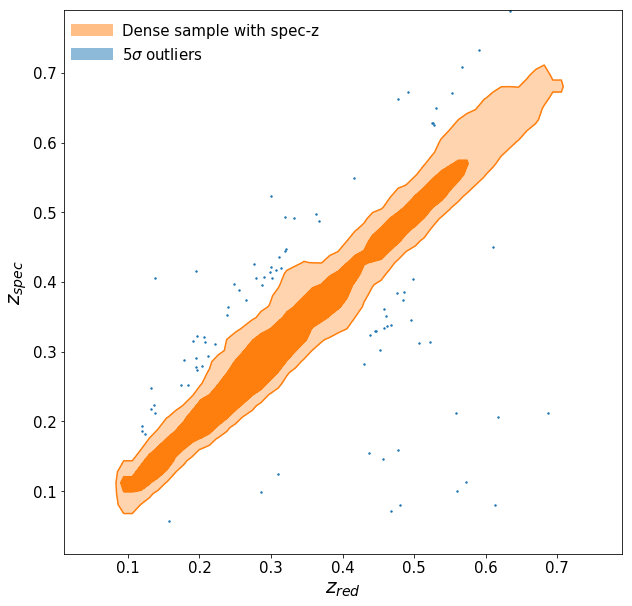

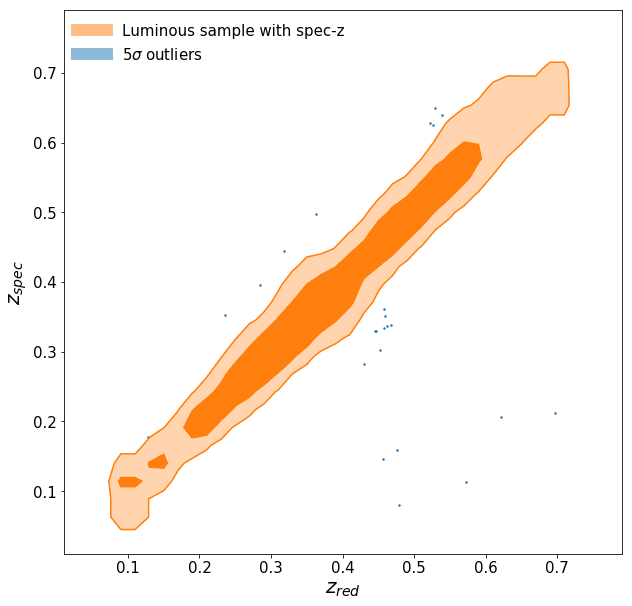

In [20]:
red_scatter_dense()
red_scatter_lum()

In [21]:
def outlier_dense():
    
    mask_one = np.where((np.in1d(ID_dense , ID_spec)==True))[0]
    mask_two = np.where((np.in1d(ID_spec,ID_dense[mask_one])==True))[0]
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_spec[mask_two])
    out_mask =  np.abs(z_dense[mask_one][arg_one] - z_spec[mask_two][arg_two])/(1+z_spec[mask_two][arg_two])>0.08
    mask_lum = z_dense[mask_one][arg_one][out_mask]
    zp_all = z_dense[mask_one][arg_one]
    zs_all = z_spec[mask_two][arg_two]
    
    plt.figure(figsize=(8,5))

    bins = np.linspace(0.1,0.7,20)
    rate = []
    err = []
    for k in range(len(bins)-1):
        
        zp = zp_all[(zp_all>bins[k])&(zp_all<bins[k+1])] 
        zs = zs_all[(zp_all>bins[k])&(zp_all<bins[k+1])]
        ez = (zp - zs)
        x75, x25 = np.percentile(ez,[84,16.])
        sz = (x75 - x25)/2
        outlier_limit = 5.*sz
        mask = np.abs(zs-zp) > outlier_limit
        rate.append(len(mask[mask==True])*1./len(mask))  
        err.append(len(mask[mask==True])*.5/len(mask))
    print "mean sigma rate" , np.mean(np.array(rate))

    plt.errorbar(0.5*(bins[1:]+bins[:-1]) , np.array(rate), err, lw = 2, fmt='-o' , capsize=3)
    
    rate = []
    err = []
    for k in range(len(bins)-1):
        
        zp = zp_all[(zp_all>bins[k])&(zp_all<bins[k+1])] 
        zs = zs_all[(zp_all>bins[k])&(zp_all<bins[k+1])]
        ez = (zp - zs)/(1+zs)
        x75, x25 = np.percentile(ez,[84,16.])
        sz = (x75 - x25)/2
        outlier_limit = 5.*sz
        mask = np.abs(zs-zp)/(1+zs) > outlier_limit
        rate.append(len(mask[mask==True])*1./len(mask))  
        err.append(len(mask[mask==True])*.5/len(mask))
    print "mean sigma rate" , np.mean(np.array(rate))

    plt.errorbar(0.5*(bins[1:]+bins[:-1]) , np.array(rate), err, lw = 2, fmt='-o' , capsize=3)
    
    plt.xticks(fontsize = 15)
    #plt.yticks([0.00, 0.02,0.04,0.06,0.08], fontsize = 15)
    plt.xlabel("photometric redshift" , fontsize = 15)
    plt.ylabel(r"$5\sigma \; \mathrm{Outlier \; Rate}$", fontsize = 15)
    plt.text( 0.2, 0.01, "Dense sample", fontsize = 20)

     
    return None


def outlier_lum():
    
    mask_one = np.where((np.in1d(ID_lum , ID_spec)==True))[0]
    mask_two = np.where((np.in1d(ID_spec,ID_lum[mask_one])==True))[0]
    arg_one = np.argsort(ID_lum[mask_one])
    arg_two = np.argsort(ID_spec[mask_two])
    out_mask =  np.abs(z_lum[mask_one][arg_one] - z_spec[mask_two][arg_two])/(1+z_spec[mask_two][arg_two])>0.08
    mask_lum = z_lum[mask_one][arg_one][out_mask]
    zp_all = z_lum[mask_one][arg_one]
    zs_all = z_spec[mask_two][arg_two]
    
    plt.figure(figsize=(8,5))

    bins = np.linspace(0.1,0.7,20)
    rate = []
    err = []

    for k in range(len(bins)-1):
        
        zp = zp_all[(zp_all>bins[k])&(zp_all<bins[k+1])] 
        zs = zs_all[(zp_all>bins[k])&(zp_all<bins[k+1])]
        ez = (zp - zs)
        x75, x25 = np.percentile(ez,[84,16.])
        sz = (x75 - x25)/2
        outlier_limit = 5.*sz
        mask = np.abs(zs-zp) > outlier_limit
        rate.append(len(mask[mask==True])*1./len(mask))  
        err.append(len(mask[mask==True])*.5/len(mask))
    print "mean sigma rate" , np.mean(np.array(rate))

    plt.errorbar(0.5*(bins[1:]+bins[:-1]) , np.array(rate), err, lw = 2, fmt='-o' , capsize=3)
    
    rate = []
    err = []
    for k in range(len(bins)-1):
        
        zp = zp_all[(zp_all>bins[k])&(zp_all<bins[k+1])] 
        zs = zs_all[(zp_all>bins[k])&(zp_all<bins[k+1])]
        ez = (zp - zs)/(1+zs)
        x75, x25 = np.percentile(ez,[84,16.])
        sz = (x75 - x25)/2
        outlier_limit = 5.*sz
        mask = np.abs(zs-zp)/(1+zs) > outlier_limit
        rate.append(len(mask[mask==True])*1./len(mask))  
        err.append(len(mask[mask==True])*.5/len(mask))
    print "mean sigma rate" , np.mean(np.array(rate))
    plt.errorbar(0.5*(bins[1:]+bins[:-1]) , np.array(rate), err, lw = 2, fmt='-o' , capsize=3)
    
    plt.xticks(fontsize = 15)
    #plt.yticks([0.00, 0.02,0.04,0.06,0.08], fontsize = 15)
    plt.xlabel("photometric redshift" , fontsize = 15)
    plt.ylabel(r"$5\sigma \; \mathrm{Outlier \; Rate}$", fontsize = 15)
    plt.text( 0.2, 0.01, "Luminous sample", fontsize = 20)

     
    return None

mean sigma rate 0.0029964159408975947
mean sigma rate 0.0022855162848435698
mean sigma rate 0.0021905475026416602
mean sigma rate 0.0017215015306063534


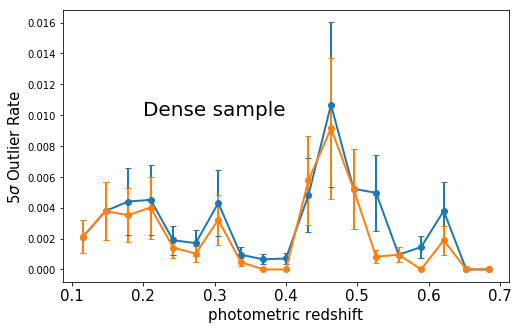

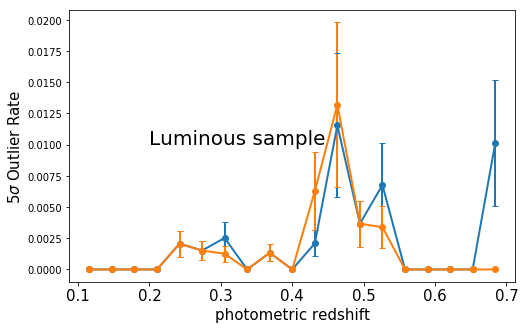

In [22]:
outlier_dense()
outlier_lum()

In [23]:
def outlier_clump(zmin, zmax):
    
    mask_one = np.where((np.in1d(ID_dense , ID_spec)==True))[0]
    mask_two = np.where((np.in1d(ID_spec,ID_dense[mask_one])==True))[0]
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_spec[mask_two])
    out_mask =  np.abs(z_dense[mask_one][arg_one] - z_spec[mask_two][arg_two])/(1+z_spec[mask_two][arg_two])>0.08
    mask_lum = z_dense[mask_one][arg_one][out_mask]
    zp_all = z_dense[mask_one][arg_one]
    
    ras_all = RA_spec[mask_two][arg_two]
    des_all = DEC_spec[mask_two][arg_two]
    zs_all = z_spec[mask_two][arg_two]
    

    zp = zp_all[(zp_all>zmin)&(zp_all<zmax)]
    zs = zs_all[(zp_all>zmin)&(zp_all<zmax)]
    
    ras = ras_all[(zp_all>zmin)&(zp_all<zmax)]
    decs = des_all[(zp_all>zmin)&(zp_all<zmax)]
    
    ez = (zp - zs)
    x75, x25 = np.percentile(ez,[84,16.])
    sz = (x75 - x25)/2
    out_limit = 5.*sz 
    core_limit = 0.02*sz
    out_mask = np.abs(zs-zp) > out_limit
    core_mask = np.abs(zs-zp) < core_limit
    
    out_ra=ras[out_mask]
    out_dec=decs[out_mask]
    core_ra=ras[core_mask]
    core_dec=decs[core_mask]
    
    print "out_ra" , out_ra
    print "out_dec", out_dec
    
    print "core_ra" , core_ra
    print "core_dec", core_dec
    
    plt.figure(figsize=(6,6))
    plt.scatter(out_ra, out_dec , label = "outlier")
    plt.scatter(core_ra, core_dec , label = "good")

    plt.legend()
     
    return None


In [701]:
def outlier_clump(zmin, zmax):
    
    mask_one = np.where((np.in1d(ID_dense , ID_spec)==True))[0]
    mask_two = np.where((np.in1d(ID_spec,ID_dense[mask_one])==True))[0]
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_spec[mask_two])
    out_mask =  np.abs(z_dense[mask_one][arg_one] - z_spec[mask_two][arg_two])/(1+z_spec[mask_two][arg_two])>0.08
    mask_lum = z_dense[mask_one][arg_one][out_mask]
    zp_all = z_dense[mask_one][arg_one]
    
    ras_all = RA_spec[mask_two][arg_two]
    des_all = DEC_spec[mask_two][arg_two]
    zs_all = z_spec[mask_two][arg_two]
    cs_all = colors_spec[mask_two][arg_two]
    zp = zp_all[(zp_all>zmin)&(zp_all<zmax)]
    zs = zs_all[(zp_all>zmin)&(zp_all<zmax)]
    cs = cs_all[(zp_all>zmin)&(zp_all<zmax)]

    
    ras = ras_all[(zp_all>zmin)&(zp_all<zmax)]
    decs = des_all[(zp_all>zmin)&(zp_all<zmax)]
    
    ez = (zp - zs)
    x75, x25 = np.percentile(ez,[84,16.])
    sz = (x75 - x25)/2
    out_limit = 5.*sz 
    core_limit = 0.01*sz
    out_mask = np.abs(zs-zp) > out_limit
    core_mask = np.abs(zs-zp) < core_limit
    
    out_ra=ras[out_mask]
    out_dec=decs[out_mask]
    core_ra=ras[core_mask]
    core_dec=decs[core_mask]
    
    print core_ra
    print core_dec
    print out_ra
    print out_dec
    
    out_cs = cs[out_mask]
    core_cs = cs[core_mask]
    
    
    plt.figure(figsize=(6,6))
    plt.scatter(core_cs[:,0], core_cs[:,1], label = "0.01-sigma precise")

    plt.scatter(out_cs[:,0], out_cs[:,1] , label = "5-sigma outlier")
    plt.xlabel("u-g", fontsize = 20)
    plt.ylabel("g-r", fontsize = 20)
    plt.legend()
     
    return None


[139.44904661 175.14822    175.3399826  175.43556519 176.31018424
 178.18928    218.37395036 219.88257966 225.03612    234.13679   ]
[ 0.24526911  2.8587826  -0.7771446   0.59724718  1.89412829  1.08443659
  2.18309279  0.43865373 -2.6397625   0.90386905]
[130.3949823  135.21524145 136.5421376  137.39109285 174.48421925
 213.05825197 216.26169785 344.7535397  348.7692962 ]
[  0.8825621   -1.16322375  -0.150268     1.75895461   1.87060269
   1.03581879   0.95024223 -32.4870843  -33.4255998 ]


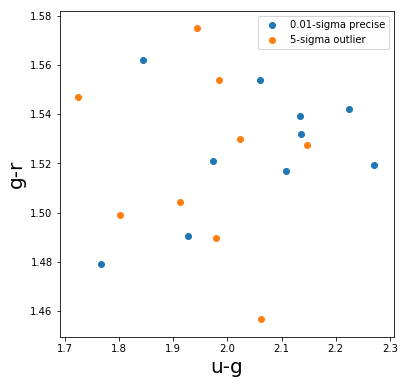

In [703]:
outlier_clump(0.29,0.31)

In [363]:
def quantile(x, q, weights=None):
    """
    Compute sample quantiles with support for weighted samples.
    Note
    ----
    When ``weights`` is ``None``, this method simply calls numpy's percentile
    function with the values of ``q`` multiplied by 100.
    Parameters
    ----------
    x : array_like[nsamples,]
       The samples.
    q : array_like[nquantiles,]
       The list of quantiles to compute. These should all be in the range
       ``[0, 1]``.
    weights : Optional[array_like[nsamples,]]
        An optional weight corresponding to each sample. These
    Returns
    -------
    quantiles : array_like[nquantiles,]
        The sample quantiles computed at ``q``.
    Raises
    ------
    ValueError
        For invalid quantiles; ``q`` not in ``[0, 1]`` or dimension mismatch
        between ``x`` and ``weights``.
    """
    x = np.atleast_1d(x)
    q = np.atleast_1d(q)

    if np.any(q < 0.0) or np.any(q > 1.0):
        raise ValueError("Quantiles must be between 0 and 1")

    if weights is None:
        return np.percentile(x, list(100.0 * q))
    else:
        weights = np.atleast_1d(weights)
        if len(x) != len(weights):
            raise ValueError("Dimension mismatch: len(weights) != len(x)")
        idx = np.argsort(x)
        sw = weights[idx]
        cdf = np.cumsum(sw)[:-1]
        cdf /= cdf[-1]
        cdf = np.append(0, cdf)
        return np.interp(q, cdf, x[idx]).tolist()
    

In [25]:
def red_bias_scatter_dense():
    nbins = 12
    bins = np.linspace(0.11 , 0.69 , nbins)
    delta = bins[1]-bins[0]
    
    
    
    mask_one = np.where((np.in1d(ID_dense, ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_dense[mask_one])==True))[0]
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    
    y2 = (z_dense[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_dense[mask_one][arg_one])
    z2 = z_dense[mask_one][arg_one] - z_specall[mask_two][arg_two]
    x2 = z_dense[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    
    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    running_bias_std = [median_absolute_deviation(z2[idx2==k]) for k in range(nbins)]
    
    print "mean bias" , np.mean(np.abs(running_bias2))
    print "mean scatter" , 1.4826*np.mean(running_mad2)
    
    plt.figure(figsize = (10,10))
    plt.plot(bins , 1.4826*np.array(running_mad2) , lw = 4, label = "SMAD")
    plt.plot(bins,1.4826*np.mean(running_mad2)*bins/bins , label = "mean scatter")
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", label = "Bias")
    plt.plot(np.linspace(0.0,1.0,200) , 0.0*np.linspace(0.1,0.8,200), "k--")
    plt.xlabel(r"$z_{red}$" , fontsize= 25)
    plt.ylabel("scatter or bias" , fontsize= 25)
    #plt.title(r"$L/L_{\star}>1$" , fontsize = 25)
    plt.legend(loc = 'best' , fontsize = 10)
    plt.xlim([0.05,0.75])
    plt.ylim([-0.009,0.029])

    plt.text( 0.1, 0.025, "Dense sample", fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    
    return None



def red_bias_scatter_lum():
    
    nbins = 12
    bins = np.linspace(0.11, 0.69 , nbins)
    delta = bins[1]-bins[0]
    
    
    
    mask_one = np.where((np.in1d(ID_lum, ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_lum[mask_one])==True))[0]
    arg_one = np.argsort(ID_lum[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    
    y2 = (z_lum[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_lum[mask_one][arg_one])
    z2 = z_lum[mask_one][arg_one] - z_specall[mask_two][arg_two]
    x2 = z_lum[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    
    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]

    print "mean bias" , np.mean(np.abs(running_bias2))
    print "mean scatter" , 1.4826*np.mean(running_mad2)
    plt.figure(figsize = (10,10))
    plt.plot(bins , 1.4826*np.array(running_mad2) , lw = 4, label = "SMAD")
    plt.plot(bins,1.4826*np.mean(running_mad2)*bins/bins , label = "mean scatter")
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", label = "Bias")
    plt.plot(np.linspace(0.0,1.0,200) , 0.0*np.linspace(0.1,0.8,200), "k--")
    plt.xlabel(r"$z_{red}$" , fontsize= 25)
    plt.ylabel("scatter or bias" , fontsize= 25)
    #plt.title(r"$L/L_{\star}>1$" , fontsize = 25)
    plt.legend(loc = 'best' , fontsize = 10)
    plt.xlim([0.05,0.75])
    plt.ylim([-0.009,0.029])
    plt.text( 0.1, 0.025, "Luminous sample", fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    return None

mean bias 0.0016450152877091888
mean scatter 0.014813348187366944
mean bias 0.0022104686972892005
mean scatter 0.014191901320308915


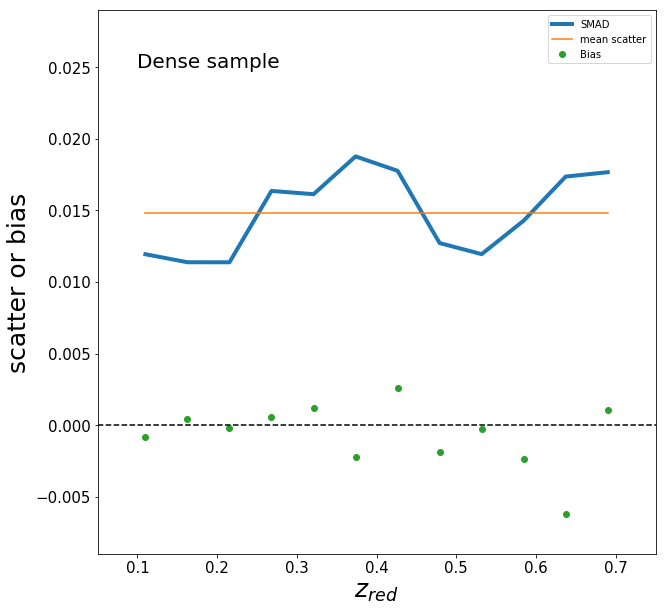

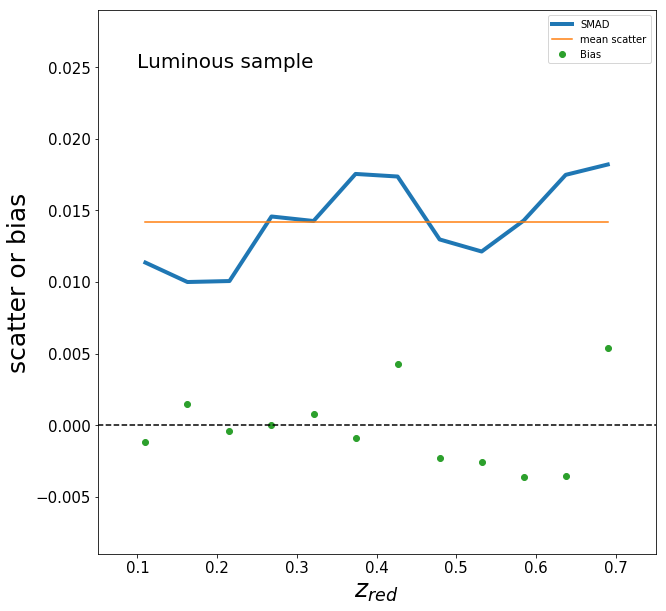

In [26]:
red_bias_scatter_dense()
red_bias_scatter_lum()

In [27]:
import corner
from matplotlib import lines as mlines
levels = [0.68,0.95,0.99]


def red_mag_dense():
    
    mask_one = np.where((np.in1d(ID_dense , ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_dense[mask_one])==True))[0]
    
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    
    plt.figure(figsize=(10,10))
    
    thick_line1 = mlines.Line2D([], [], ls='-', c='#FF7F0E', linewidth=12, alpha=0.5, 
                                label="dense sample with spec-z")
    thick_line2 = mlines.Line2D([], [], ls='-', c='#1F77B4', linewidth=12, alpha=0.5, 
                                label="dense sample")
    
    corner.hist2d(z_dense[mask_one][arg_one] , mi_specall[mask_two][arg_two], color='#FF7F0E', plot_datapoints=False,
                 bins=100, levels=levels, fill_contours=True, smooth=1.0)
    
    corner.hist2d(z_dense , mi_dense, color='#1F77B4', plot_datapoints=False,
                 bins=100, levels=levels, fill_contours=True, smooth=1.0)
    plt.legend(loc='upper left', handles=[thick_line2, thick_line1], 
               frameon=False, fontsize=15, handletextpad=1.0, scatteryoffsets=[0.5])

    plt.xlim((0.05,0.75))
    plt.ylim(16,22)

    plt.xlabel("$z_{red}$" , fontsize = 20)
    plt.ylabel("$i-band \; magnitude$" , fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)

    return None

def red_mag_lum():
    
    mask_one = np.where((np.in1d(ID_lum , ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_lum[mask_one])==True))[0]
    
    arg_one = np.argsort(ID_lum[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    
    plt.figure(figsize=(10,10))
    
    
    
    
    
    corner.hist2d(z_lum[mask_one][arg_one] , mi_specall[mask_two][arg_two], color='#FF7F0E', plot_datapoints=False,
                 bins=50, levels=levels, fill_contours=True, smooth=1.0, label = "luminous sample with spec-z")
    corner.hist2d(z_lum , mi_lum, color='#1F77B4',plot_datapoints=False,
                 bins=50, levels=levels, fill_contours=True, smooth=1.0, label = "luminous sample")
    thick_line1 = mlines.Line2D([], [], ls='-', c='#FF7F0E', linewidth=12, alpha=0.5, 
                                label="luminous sample with spec-z")
    thick_line2 = mlines.Line2D([], [], ls='-', c='#1F77B4', linewidth=12, alpha=0.5, 
                                label="luminous sample")
    plt.legend(loc='upper left', handles=[thick_line2, thick_line1], 
               frameon=False, fontsize=15, handletextpad=1.0, scatteryoffsets=[0.5])
    plt.xlim((0.05,0.75))
    plt.ylim(16,22)
    plt.xlabel("$z_{red}$" , fontsize = 20)
    plt.ylabel("$i-band \; magnitude$" , fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)

    return None

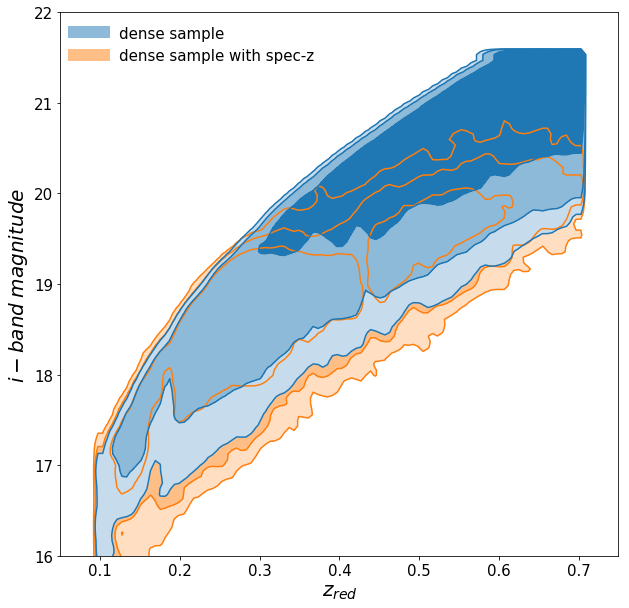

In [28]:
red_mag_dense()

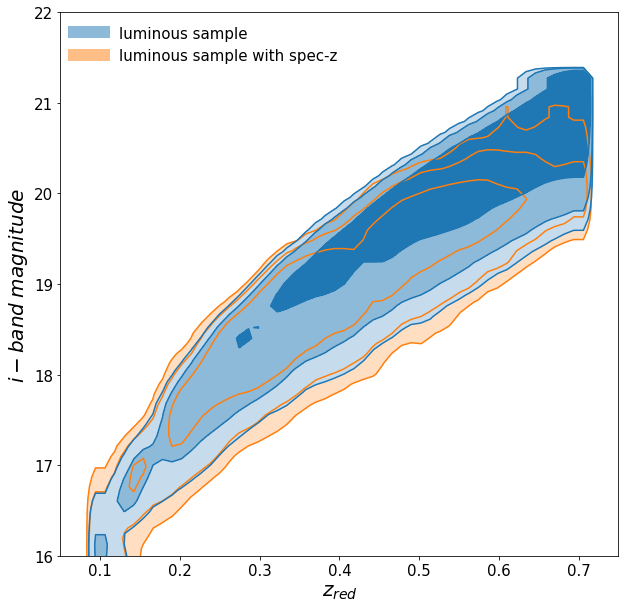

In [29]:
red_mag_lum()

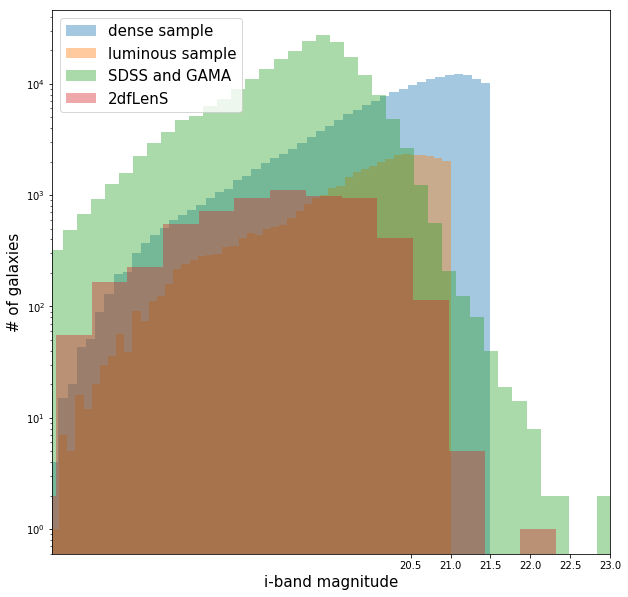

In [37]:
plt.figure(figsize = (10,10))
sns.distplot(mi_dense , kde =False , label="dense sample")
sns.distplot(mi_lum , kde = False , label = "luminous sample")
sns.distplot(mi_spec , kde = False , label = "SDSS and GAMA")
sns.distplot(mi_2df , kde = False , label = "2dfLenS")
plt.xticks([20.5,21,21.5,22,22.5,23])
plt.xlim([16,23])
plt.legend(loc='best' , fontsize = 15)
plt.xlabel("i-band magnitude" , fontsize = 15)
plt.ylabel("# of galaxies" , fontsize = 15)
plt.yscale("log")

In [29]:
def mi_bias_scatter_dense_2df():
    nbins = 10
    bins = np.logspace(np.log10(17.5),np.log10(21.),nbins)
    delta = bins[1]-bins[0]
    
    scatter
    
    mask_one = np.where((np.in1d(ID_dense, ID_2df)==True))[0]
    mask_two = np.where((np.in1d(ID_2df,ID_dense[mask_one])==True))[0]
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_2df[mask_two])
    
    y2 = (z_dense[mask_one][arg_one] - z_2df[mask_two][arg_two])/(1+z_dense[mask_one][arg_one])
    z2 = z_dense[mask_one][arg_one] - z_2df[mask_two][arg_two]
    x2 = mi_dense[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    
    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]

    
    plt.figure(figsize = (10,10))
    #lt.plot(bins , running_sigma682 , lw= 4, label = r"$\sigma_{68}/(1+z)$")
    plt.plot(bins , running_mad2 , lw = 4, label = "scatter")
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", label = r"$\mathrm{bias} \; \delta z$")
    #plt.errorbar(bins , running_bias , yerr = running_bias_std, color = "blue" , label = r"$\mathrm{bias} \; \delta z$")
    #lt.plot(np.linspace(0.0,1.0,200) , 0.0*np.linspace(0.1,0.8,200), "k--")
    plt.xlabel(r"$m_i$" , fontsize= 25)
    plt.ylabel("scatter or bias" , fontsize= 25)
    #plt.title(r"$L/L_{\star}>1$" , fontsize = 25)
    plt.legend(loc = 'best' , fontsize = 10)
    #lt.xlim([0.05,0.75])
    plt.ylim([-0.1,0.025])

    #lt.text( 0.2, 0.02, "$L/L_{\star}>0.5$", fontsize = 30)

    
    return None



def mi_bias_scatter_lum_2df():
    
    nbins = 10
    bins = np.logspace(np.log10(17.5),np.log10(21.),nbins)
    print bins
    delta = bins[1]-bins[0]
    
   
    
    mask_one = np.where((np.in1d(ID_lum, ID_2df)==True))[0]
    mask_two = np.where((np.in1d(ID_2df,ID_lum[mask_one])==True))[0]
    arg_one = np.argsort(ID_lum[mask_one])
    arg_two = np.argsort(ID_2df[mask_two])
    
    y2 = (z_lum[mask_one][arg_one] - z_2df[mask_two][arg_two])/(1+z_lum[mask_one][arg_one])
    z2 = z_lum[mask_one][arg_one] - z_2df[mask_two][arg_two]
    x2 = mi_lum[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    
    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]

    
    plt.figure(figsize = (10,10))
    #lt.plot(bins , running_sigma682 , lw= 4, label = r"$\sigma_{68}/(1+z)$")
    plt.plot(bins , running_mad2 , lw = 4, label = "scatter")
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", label = r"$\mathrm{bias} \; \delta z$")
    #plt.errorbar(bins , running_bias , yerr = running_bias_std, color = "blue" , label = r"$\mathrm{bias} \; \delta z$")
    #lt.plot(np.linspace(0.0,1.0,200) , 0.0*np.linspace(0.1,0.8,200), "k--")
    plt.xlabel(r"$m_i$" , fontsize= 25)
    plt.ylabel("scatter or bias" , fontsize= 25)
    #plt.title(r"$L/L_{\star}>1$" , fontsize = 25)
    plt.legend(loc = 'best' , fontsize = 10)
    #lt.xlim([0.05,0.75])
    plt.ylim([-0.1,0.025])

    #lt.text( 0.2, 0.02, "$L/L_{\star}>0.5$", fontsize = 30)

    
    return None


[17.5        17.85812937 18.2235877  18.59652496 18.97709421 19.36545163
 19.76175661 20.16617178 20.57886312 21.        ]


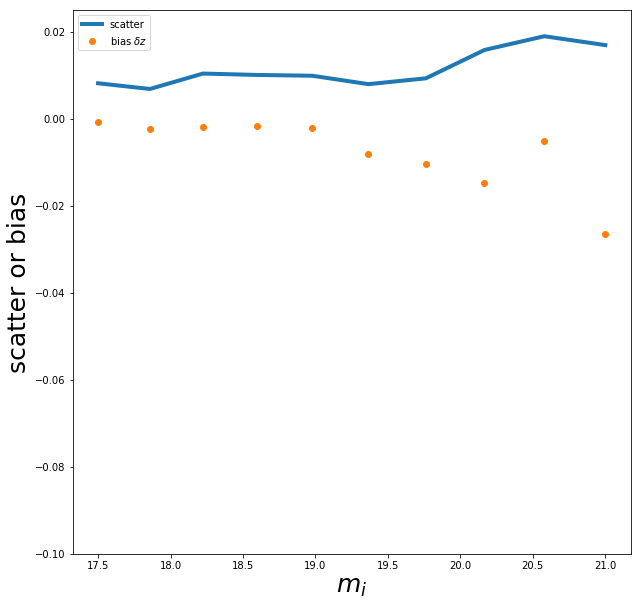

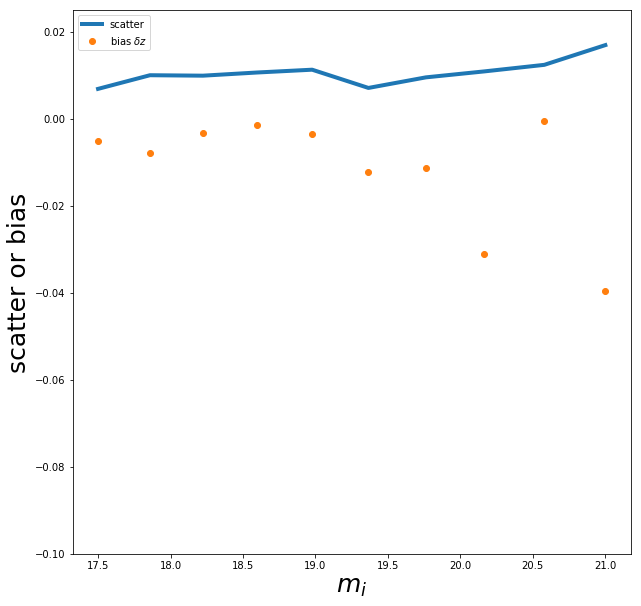

In [30]:
mi_bias_scatter_dense_2df()
mi_bias_scatter_lum_2df()

In [37]:
def mi_bias_scatter_dense_spec():
    plt.figure(figsize = (10,10))

    
    nbins = 10
    bins = np.logspace(np.log10(17.5),np.log10(21.),nbins)
    delta = bins[1]-bins[0]

    mask_one = np.where((np.in1d(ID_dense, ID_spec)==True))[0]
    mask_two = np.where((np.in1d(ID_spec,ID_dense[mask_one])==True))[0]
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_spec[mask_two])
    
    y2 = (z_dense[mask_one][arg_one] - z_spec[mask_two][arg_two])/(1+z_dense[mask_one][arg_one])
    z2 = z_dense[mask_one][arg_one] - z_spec[mask_two][arg_two]
    x2 = mi_dense[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    #plt.plot(bins , running_mad2 , lw = 4, label = "scatter")
    #plt.plot(bins , -1.*running_mad2 ,lw = 4, label = "scatter")
    plt.fill_between(bins , -1.*np.array(running_mad2) , running_mad2, alpha = 0.2)
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", label = r"$\mathrm{bias} \; \delta z$")
    
    nbins = 10
    bins = np.logspace(np.log10(17.5),np.log10(21.),nbins)
    delta = bins[1]-bins[0]
    mask_one = np.where((np.in1d(ID_dense, ID_2df)==True))[0]
    mask_two = np.where((np.in1d(ID_2df,ID_dense[mask_one])==True))[0]
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_2df[mask_two])
    y2 = (z_dense[mask_one][arg_one] - z_2df[mask_two][arg_two])/(1+z_dense[mask_one][arg_one])
    z2 = z_dense[mask_one][arg_one] - z_2df[mask_two][arg_two]
    x2 = mi_dense[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    plt.fill_between(bins , -1.*np.array(running_mad2) , running_mad2, alpha = 0.2)

    #plt.plot(bins , running_mad2 , lw = 4, label = "scatter")
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", label = r"$\mathrm{bias} \; \delta z$")
    
    
    plt.plot(bins , 0.0*bins, "k--")
    plt.xlabel(r"$m_i$" , fontsize= 25)
    plt.ylabel("scatter or bias" , fontsize= 25)
    plt.legend(loc = 'best' , fontsize = 10)
    plt.ylim([-0.04,0.025])
    
    return None



def mi_bias_scatter_lum_spec():
    
    plt.figure(figsize = (10,10))

    
    nbins = 10
    bins = np.logspace(np.log10(17.5),np.log10(21.),nbins)
    delta = bins[1]-bins[0]

    mask_one = np.where((np.in1d(ID_lum, ID_spec)==True))[0]
    mask_two = np.where((np.in1d(ID_spec,ID_lum[mask_one])==True))[0]
    arg_one = np.argsort(ID_lum[mask_one])
    arg_two = np.argsort(ID_spec[mask_two])
    
    y2 = (z_lum[mask_one][arg_one] - z_spec[mask_two][arg_two])/(1+z_lum[mask_one][arg_one])
    z2 = z_lum[mask_one][arg_one] - z_spec[mask_two][arg_two]
    x2 = mi_lum[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    #plt.plot(bins , running_mad2 , lw = 4, label = "scatter")
    plt.fill_between(bins , -1.*np.array(running_mad2) , running_mad2, alpha = 0.2)
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", label = r"$\mathrm{bias} \; \delta z$")
    
    nbins = 10
    bins = np.logspace(np.log10(17.5),np.log10(21.),nbins)
    delta = bins[1]-bins[0]
    mask_one = np.where((np.in1d(ID_lum, ID_2df)==True))[0]
    mask_two = np.where((np.in1d(ID_2df,ID_lum[mask_one])==True))[0]
    arg_one = np.argsort(ID_lum[mask_one])
    arg_two = np.argsort(ID_2df[mask_two])
    y2 = (z_lum[mask_one][arg_one] - z_2df[mask_two][arg_two])/(1+z_lum[mask_one][arg_one])
    z2 = z_lum[mask_one][arg_one] - z_2df[mask_two][arg_two]
    x2 = mi_lum[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    #plt.plot(bins , running_mad2 , lw = 4, label = "scatter")
    plt.fill_between(bins , -1.*np.array(running_mad2) , running_mad2, alpha = 0.2)
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", label = r"$\mathrm{bias} \; \delta z$")
    
    
    plt.plot(bins , 0.0*bins, "k--")
    plt.xlabel(r"$m_i$" , fontsize= 25)
    plt.ylabel("scatter or bias" , fontsize= 25)
    plt.legend(loc = 'best' , fontsize = 10)
    plt.ylim([-0.04,0.025])

    return None


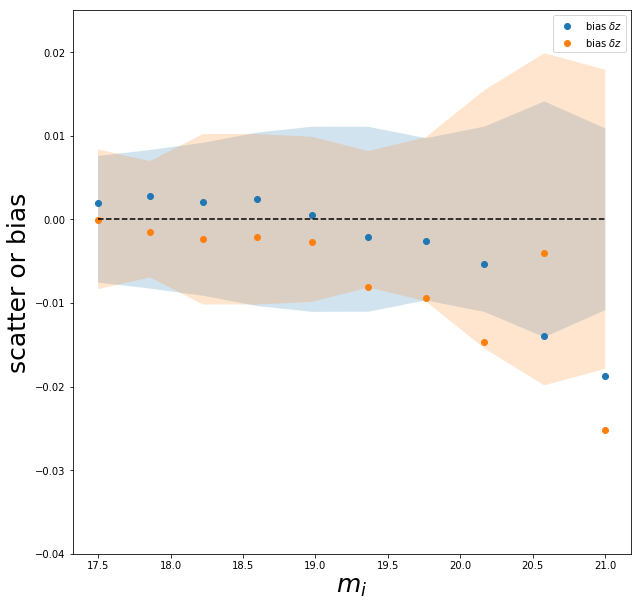

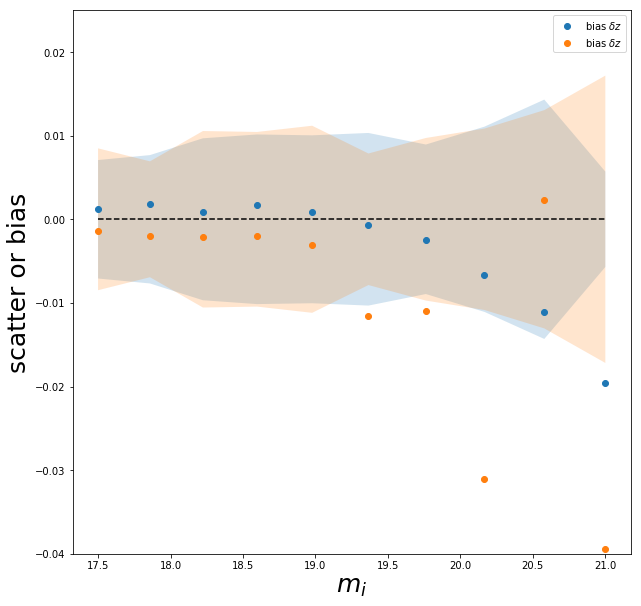

In [38]:
mi_bias_scatter_dense_spec()
mi_bias_scatter_lum_spec()

In [39]:
def z_bias_scatter_dense_spec():
    plt.figure(figsize = (10,10))

    
    nbins = 15
    bins = np.linspace(0.11,0.7,nbins)
    delta = bins[1]-bins[0]

    mask_one = np.where((np.in1d(ID_dense, ID_spec)==True))[0]
    mask_two = np.where((np.in1d(ID_spec,ID_dense[mask_one])==True))[0]
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_spec[mask_two])
    print arg_two.shape , "specx dense lrg"

    y2 = (z_dense[mask_one][arg_one] - z_spec[mask_two][arg_two])/(1+z_spec[mask_two][arg_two])
    z2 = z_dense[mask_one][arg_one] - z_spec[mask_two][arg_two]
    x2 = z_dense[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    #plt.plot(bins , running_mad2 , lw = 4, label = "scatter")
    #plt.plot(bins , -1.*running_mad2 ,lw = 4, label = "scatter")
    plt.fill_between(bins , -1.*np.array(running_mad2) , running_mad2, alpha = 0.2)
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", label = r"$\mathrm{bias} \; \delta z$")
    
    nbins = 15
    bins = np.linspace(0.11,0.7,nbins)
    delta = bins[1]-bins[0]
    mask_one = np.where((np.in1d(ID_dense, ID_2df)==True))[0]
    mask_two = np.where((np.in1d(ID_2df,ID_dense[mask_one])==True))[0]
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_2df[mask_two])
    print arg_two.shape , "2df x dense lrg"

    y2 = (z_dense[mask_one][arg_one] - z_2df[mask_two][arg_two])/(1+z_spec[mask_two][arg_two])
    z2 = z_dense[mask_one][arg_one] - z_2df[mask_two][arg_two]
    x2 = z_dense[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    plt.fill_between(bins , -1.*np.array(running_mad2) , running_mad2, alpha = 0.2)

    #plt.plot(bins , running_mad2 , lw = 4, label = "scatter")
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", label = r"$\mathrm{bias} \; \delta z$")
    
    
    plt.plot(bins , 0.0*bins, "k--")
    plt.xlabel(r"$z$" , fontsize= 25)
    plt.ylabel("scatter or bias" , fontsize= 25)
    plt.legend(loc = 'best' , fontsize = 10)
    plt.ylim([-0.04,0.025])
    
    return None



def z_bias_scatter_lum_spec():
    
    plt.figure(figsize = (10,10))

    
    nbins = 15
    bins = np.linspace(0.15,0.7,nbins)
    delta = bins[1]-bins[0]

    mask_one = np.where((np.in1d(ID_lum, ID_spec)==True))[0]
    mask_two = np.where((np.in1d(ID_spec,ID_lum[mask_one])==True))[0]
    arg_one = np.argsort(ID_lum[mask_one])
    arg_two = np.argsort(ID_spec[mask_two])
    print arg_two.shape , "specxlrg"

    y2 = (z_lum[mask_one][arg_one] - z_spec[mask_two][arg_two])/(1+z_spec[mask_two][arg_two])
    z2 = z_lum[mask_one][arg_one] - z_spec[mask_two][arg_two]
    x2 = z_lum[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    #plt.plot(bins , running_mad2 , lw = 4, label = "scatter")
    plt.fill_between(bins , -1.*np.array(running_mad2) , running_mad2, alpha = 0.2)
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", label = r"$\mathrm{bias} \; \delta z$")
    
    nbins = 15
    bins = np.linspace(0.15,0.7,nbins)
    delta = bins[1]-bins[0]
    mask_one = np.where((np.in1d(ID_lum, ID_2df)==True))[0]
    mask_two = np.where((np.in1d(ID_2df,ID_lum[mask_one])==True))[0]
    arg_one = np.argsort(ID_lum[mask_one])
    arg_two = np.argsort(ID_2df[mask_two])
    print arg_two.shape , "2dfxlrg"
    y2 = (z_lum[mask_one][arg_one] - z_2df[mask_two][arg_two])/(1+z_spec[mask_two][arg_two])
    z2 = z_lum[mask_one][arg_one] - z_2df[mask_two][arg_two]
    x2 = z_lum[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    #plt.plot(bins , running_mad2 , lw = 4, label = "scatter")
    plt.fill_between(bins , -1.*np.array(running_mad2) , running_mad2, alpha = 0.2)
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", label = r"$\mathrm{bias} \; \delta z$")
    
    
    plt.plot(bins , 0.0*bins, "k--")
    plt.xlabel(r"$z$" , fontsize= 25)
    plt.ylabel("scatter or bias" , fontsize= 25)
    plt.legend(loc = 'best' , fontsize = 10)
    plt.ylim([-0.04,0.025])

    return None


(27218,) specx dense lrg
(1115,) 2df x dense lrg
(9492,) specxlrg
(480,) 2dfxlrg


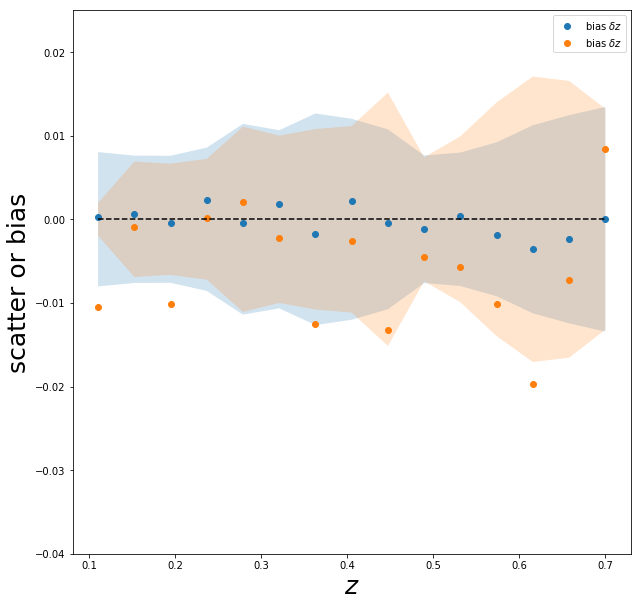

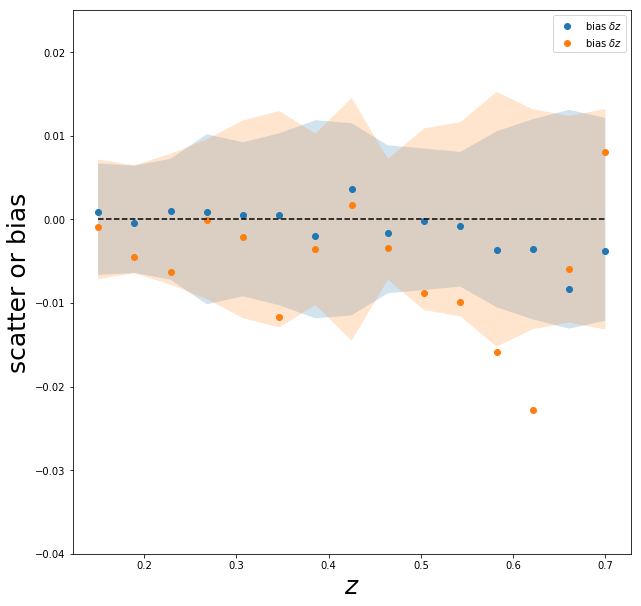

In [40]:
z_bias_scatter_dense_spec()
z_bias_scatter_lum_spec()

In [41]:
mask_one = np.where((np.in1d(ID_kids , ID_2df)==True))[0]
mask_two = np.where((np.in1d(ID_2df  , ID_kids[mask_one])==True))[0]
    
arg_one = np.argsort(ID_kids[mask_one])
arg_two = np.argsort(ID_2df[mask_two])

In [173]:
colors_2df = colors[mask_one][arg_one]
mi_2df = mi[mask_one][arg_one]
z_2df_sort = z_2df[mask_two][arg_two]

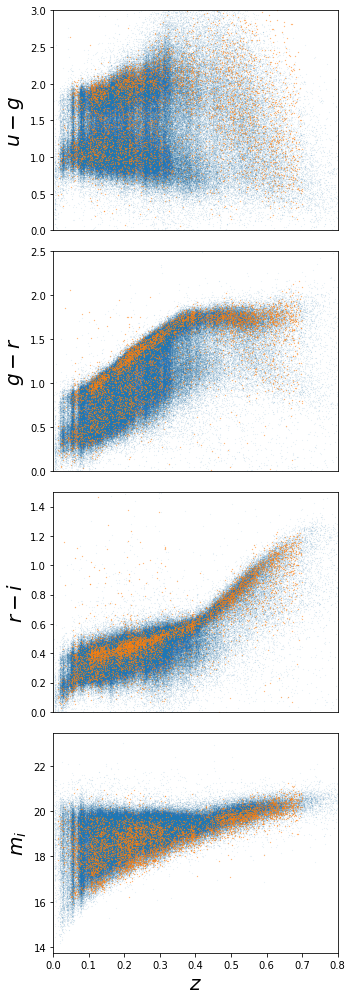

In [175]:
fig , ax = plt.subplots(nrows=4,ncols=1 , figsize=(5,14))


ax[0].scatter(z_spec , color_spec[:,0] , s = 0.001 )
ax[1].scatter(z_spec , color_spec[:,1] , s = 0.001)
ax[2].scatter(z_spec , color_spec[:,2] , s = 0.001)
ax[3].scatter(z_spec, mi_spec, s= 0.001)

ax[0].scatter(z_2df_sort , colors_2df[:,0] , s = 0.05 )
ax[1].scatter(z_2df_sort , colors_2df[:,1] , s = 0.05)
ax[2].scatter(z_2df_sort , colors_2df[:,2] , s = 0.05)
ax[3].scatter(z_2df_sort, mi_2df, s= 0.05)


ax[0].set_xlim(0,0.8)
ax[0].set_ylim(0,3)
ax[0].set_xticks([])

ax[1].set_xlim(0,0.8)
ax[1].set_ylim(0,2.5)
ax[1].set_xticks([])

ax[2].set_xlim(0,0.8)
ax[2].set_ylim(0,1.5)
ax[2].set_xticks([])

ax[3].set_xlim(0,0.8)


ax[3].set_xlabel(r"$z$" , fontsize = 20)
ax[0].set_ylabel(r"$u-g$" , fontsize = 20)
ax[1].set_ylabel(r"$g-r$" , fontsize = 20)
ax[2].set_ylabel(r"$r-i$" , fontsize = 20)
ax[3].set_ylabel(r"$m_i$" , fontsize = 20)

plt.tight_layout()

In [194]:
colors_2df[:,0].shape

(5571,)

In [53]:
mask_one = np.where((np.in1d(ID_kids , ID_dense)==True))[0]
mask_two = np.where((np.in1d(ID_dense  , ID_kids[mask_one])==True))[0]
    
arg_one = np.argsort(ID_kids[mask_one])
arg_two = np.argsort(ID_dense[mask_two])

In [54]:
colors_dense = colors[mask_one][arg_one]
mi_dense = mi[mask_one][arg_one]
z_dense_sort = z_dense[mask_two][arg_two]

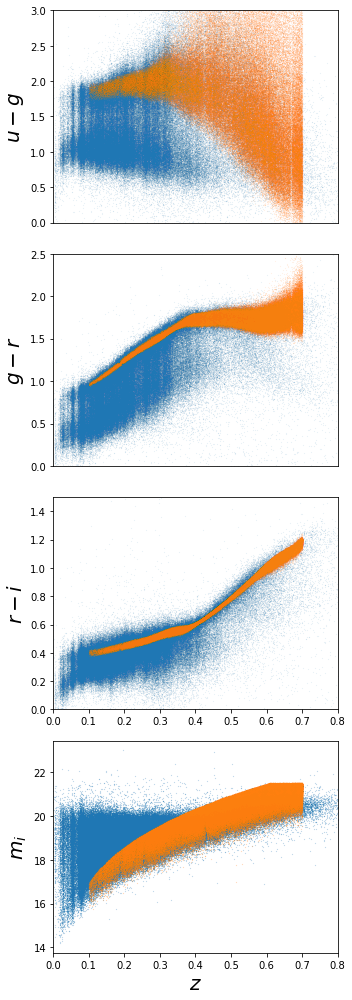

In [55]:
fig , ax = plt.subplots(nrows=4,ncols=1 , figsize=(5,14))


ax[0].scatter(z_spec , color_spec[:,0] , s = 0.001 )
ax[1].scatter(z_spec , color_spec[:,1] , s = 0.001)
ax[2].scatter(z_spec , color_spec[:,2] , s = 0.001)
ax[3].scatter(z_spec , mi_spec , s = 0.01)


ax[0].scatter(z_dense_sort , colors_dense[:,0] , s = 0.001 )
ax[1].scatter(z_dense_sort , colors_dense[:,1] , s = 0.001)
ax[2].scatter(z_dense_sort , colors_dense[:,2] , s = 0.001)
ax[3].scatter(z_dense_sort, mi_dense, s= 0.01)

ax[0].set_xlim(0,0.8)
ax[0].set_ylim(0,3)
ax[0].set_xticks([])

ax[1].set_xlim(0,0.8)
ax[1].set_ylim(0,2.5)
ax[1].set_xticks([])

ax[2].set_xlim(0,0.8)
ax[2].set_ylim(0,1.5)

ax[3].set_xlim(0,0.8)


ax[3].set_xlabel(r"$z$" , fontsize = 20)
ax[0].set_ylabel(r"$u-g$" , fontsize = 20)
ax[1].set_ylabel(r"$g-r$" , fontsize = 20)
ax[2].set_ylabel(r"$r-i$" , fontsize = 20)
ax[3].set_ylabel(r"$m_i$" , fontsize = 20)

plt.tight_layout()

In [31]:
mask_one = np.where((np.in1d(ID_kids , ID_lum)==True))[0]
mask_two = np.where((np.in1d(ID_lum  , ID_kids[mask_one])==True))[0]


arg_one = np.argsort(ID_kids[mask_one])
arg_two = np.argsort(ID_lum[mask_two])

In [166]:
colors_lum = colors[mask_one][arg_one]
z_lum_sort = z_lum[mask_two][arg_two]
mi_lum = mi[mask_one][arg_one]

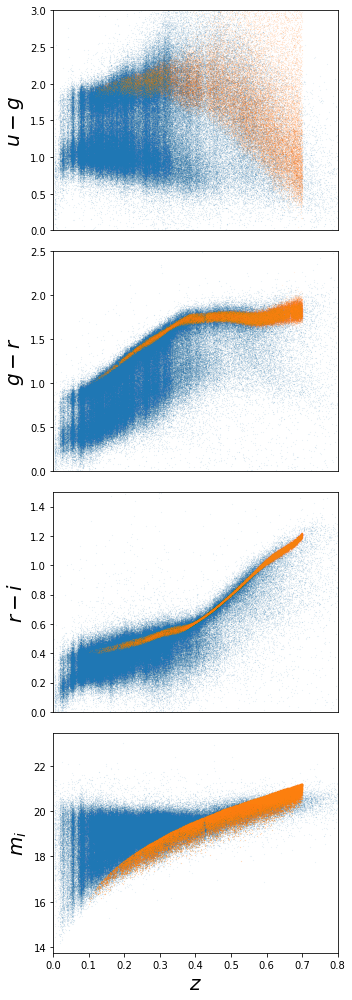

In [168]:
fig , ax = plt.subplots(nrows=4,ncols=1 , figsize=(5,14))


ax[0].scatter(z_spec , color_spec[:,0] , s = 0.001 )
ax[1].scatter(z_spec , color_spec[:,1] , s = 0.001)
ax[2].scatter(z_spec , color_spec[:,2] , s = 0.001)
ax[3].scatter(z_spec, mi_spec, s= .001)

ax[0].scatter(z_lum_sort , colors_lum[:,0] , s = 0.001 )
ax[1].scatter(z_lum_sort , colors_lum[:,1] , s = 0.001)
ax[2].scatter(z_lum_sort , colors_lum[:,2] , s = 0.001)
ax[3].scatter(z_lum_sort, mi_lum, s = 0.01)

ax[0].set_xlim(0,0.8)
ax[0].set_ylim(0,3)
ax[0].set_xticks([])

ax[1].set_xlim(0,0.8)
ax[1].set_ylim(0,2.5)
ax[1].set_xticks([])

ax[2].set_xlim(0,0.8)
ax[2].set_ylim(0,1.5)
ax[2].set_xticks([])

ax[3].set_xlim(0,0.8)

ax[3].set_xlabel(r"$z$" , fontsize = 20)
ax[0].set_ylabel(r"$u-g$" , fontsize = 20)
ax[1].set_ylabel(r"$g-r$" , fontsize = 20)
ax[2].set_ylabel(r"$r-i$" , fontsize = 20)
ax[3].set_ylabel(r"$m_i$" , fontsize = 20)

plt.tight_layout()

In [56]:
def red_bias_scatter_dense():
    plt.figure(figsize = (10,10))
    nbins = 10
    bins = np.linspace(0.11 , 0.7 , nbins)
    delta = bins[1]-bins[0]
    
    
    
    mask_one = np.where((np.in1d(ID_dense, ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_dense[mask_one])==True))[0]
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    
    y2 = (z_dense[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_dense[mask_one][arg_one])
    z2 = z_dense[mask_one][arg_one] - z_specall[mask_two][arg_two]
    x2 = z_dense[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    ID_dense_copy = ID_dense[mask_one][arg_one]
    z_spec_matched_to_dense = z_specall[mask_two][arg_two]
    
    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]

    
    plt.plot(bins , running_mad2 , lw = 4, color = '#FF7F0E', label = "mad redMaGiC")
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", color = '#FF7F0E', label = "bias redMaGiC")
    
    
    mask_one = np.where((np.in1d(ID_kids, ID_dense_copy)==True))[0]
    mask_two = np.where((np.in1d(ID_dense_copy,ID_kids[mask_one])==True))[0]
    arg_one = np.argsort(ID_kids[mask_one])
    arg_two = np.argsort(ID_dense_copy[mask_two])
    
    y2 = (z_ann[mask_one][arg_one] - z_spec_matched_to_dense[mask_two][arg_two])/(1+z_ann[mask_one][arg_one])
    z2 = z_ann[mask_one][arg_one] - z_spec_matched_to_dense[mask_two][arg_two]
    x2 = z_ann[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)
    
    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    
    #plt.plot(bins , running_sigma682 , lw= 4, color = '#1F77B4', label = r"$\sigma_{68}/(1+z)$")
    plt.plot(bins , running_mad2 , lw = 4, color = '#1F77B4', label = "mad ANNz2")
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", color = '#1F77B4', label = "bias ANNz2")
    
    plt.plot(np.linspace(0.0,1.0,200) , 0.0*np.linspace(0.1,0.8,200), "k--")
    plt.xlabel(r"$z_{phot}$" , fontsize= 25)
    plt.ylabel("scatter or bias" , fontsize= 25)
    plt.legend(loc = 'best' , fontsize = 10)
    plt.xlim([0.05,0.75])
    plt.ylim([-0.05,0.05])
    plt.text( 0.2, 0.03, "$L/L_{\star}>0.5$", fontsize = 30)

    
    return None

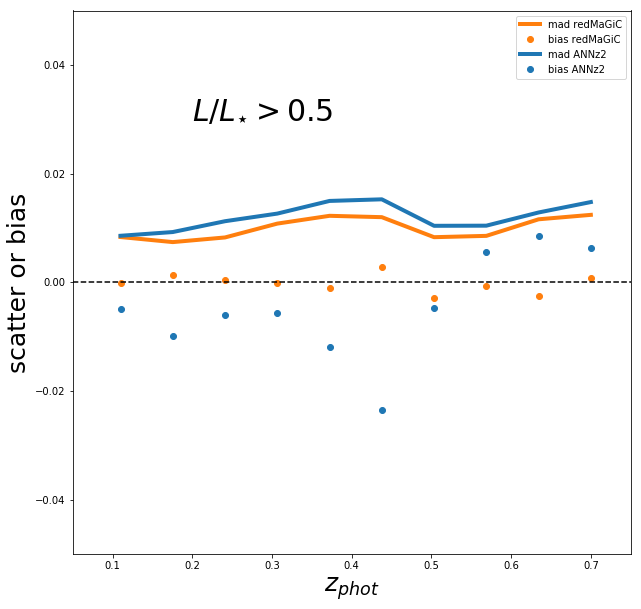

In [57]:
red_bias_scatter_dense()

In [30]:
def red_bias_scatter_dense():
    plt.figure(figsize = (10,10))
    nbins = 10
    bins = np.linspace(0.11 , 0.7 , nbins)
    delta = bins[1]-bins[0]
    
    
    
    mask_one = np.where((np.in1d(ID_dense, ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_dense[mask_one])==True))[0]
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    
    y2 = (z_dense[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_dense[mask_one][arg_one])
    z2 = z_dense[mask_one][arg_one] - z_specall[mask_two][arg_two]
    x2 = z_dense[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    ID_dense_copy = ID_dense[mask_one][arg_one]
    z_spec_matched_to_dense = z_specall[mask_two][arg_two]
    
    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]

    print "mean bias" , np.mean(np.abs(running_bias2))
    print "mean scatter" , 1.4826*np.mean(running_mad2)
    out_mask =  (z_dense[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_specall[mask_two][arg_two])>0.08
    print "5sigma outlier fraction" , np.where(out_mask==True)[0].shape[0]*1.0*100/out_mask.shape[0]
    
    plt.plot(bins , 1.4826*np.array(running_mad2) , lw = 4, color = '#FF7F0E', label = "SMAD redMaGiC")
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", color = '#FF7F0E', label = "Bias redMaGiC")
    
    
    mask_one = np.where((np.in1d(ID_kids, ID_dense_copy)==True))[0]
    mask_two = np.where((np.in1d(ID_dense_copy,ID_kids[mask_one])==True))[0]
    arg_one = np.argsort(ID_kids[mask_one])
    arg_two = np.argsort(ID_dense_copy[mask_two])
    
    y2 = (z_ann[mask_one][arg_one] - z_spec_matched_to_dense[mask_two][arg_two])/(1+z_ann[mask_one][arg_one])
    z2 = z_ann[mask_one][arg_one] - z_spec_matched_to_dense[mask_two][arg_two]
    x2 = z_ann[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)
    
    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    
    print "mean bias" , np.mean(np.abs(running_bias2))
    print "mean scatter" , 1.4826*np.mean(running_mad2)
    out_mask =  (z_ann[mask_one][arg_one] - z_spec_matched_to_dense[mask_two][arg_two])/(1+z_spec_matched_to_dense[mask_two][arg_two])>0.08
    print "5sigma outlier fraction" , np.where(out_mask==True)[0].shape[0]*1.0*100/out_mask.shape[0]
    
    #plt.plot(bins , running_sigma682 , lw= 4, color = '#1F77B4', label = r"$\sigma_{68}/(1+z)$")
    plt.plot(bins , 1.4826*np.array(running_mad2) , lw = 4, color = '#1F77B4', label = "SMAD ANNz2")
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", color = '#1F77B4', label = "Bias ANNz2")
    
    nbins = 10
    bins = np.linspace(0.13 , 0.67 , nbins)
    delta = bins[1]-bins[0]
    
    y2 = (z_bpz[mask_one][arg_one] - z_spec_matched_to_dense[mask_two][arg_two])/(1+z_ann[mask_one][arg_one])
    z2 = z_bpz[mask_one][arg_one] - z_spec_matched_to_dense[mask_two][arg_two]
    x2 = z_bpz[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)
    
    
    
    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    
    print "mean bias" , np.mean(np.abs(running_bias2))
    print "mean scatter" , 1.4826*np.mean(running_mad2)
    out_mask =  (z_bpz[mask_one][arg_one] - z_spec_matched_to_dense[mask_two][arg_two])/(1+z_spec_matched_to_dense[mask_two][arg_two])>0.08
    print "5sigma outlier fraction" , np.where(out_mask==True)[0].shape[0]*1.0*100/out_mask.shape[0]
    
    
    #plt.plot(bins , running_sigma682 , lw= 4, color = '#1F77B4', label = r"$\sigma_{68}/(1+z)$")
    plt.plot(bins , 1.4826*np.array(running_mad2) , lw = 4, color = 'red', label = "SMAD BPZ")
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", color = 'red', label = "Bias BPZ")
    
    
    plt.plot(np.linspace(0.0,1.0,200) , 0.0*np.linspace(0.1,0.8,200), "k--")
    plt.xlabel(r"$z_{phot}$" , fontsize= 25)
    plt.ylabel("scatter or bias" , fontsize= 25)
    plt.legend(loc = 'best' , fontsize = 10)
    plt.xlim([0.05,0.75])
    plt.ylim([-0.06,0.06])
    plt.text( 0.1, 0.045, "Dense sample", fontsize = 20)

    
    return None

mean bias 0.0014778858839714255
mean scatter 0.014889031858780141
5sigma outlier fraction 0.10824126605
mean bias 0.00692960756283634
mean scatter 0.017729484125371314
5sigma outlier fraction 0.235144819349
mean bias 0.016722287162065506
mean scatter 0.01868105117769889
5sigma outlier fraction 0.418035234398


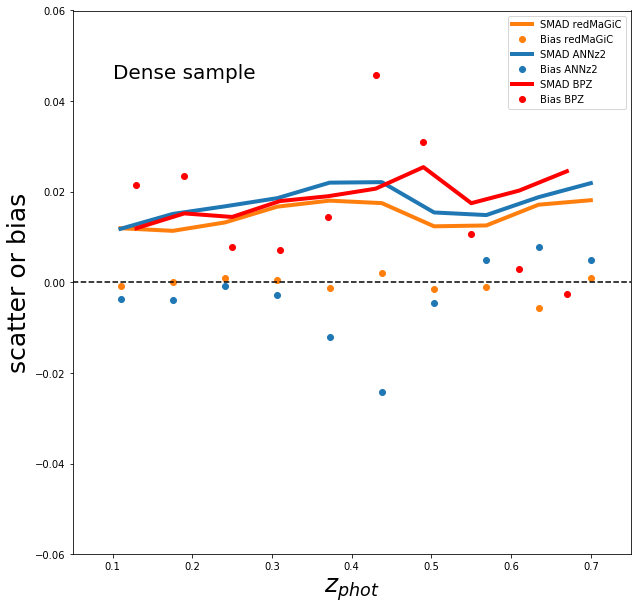

In [31]:
red_bias_scatter_dense()

In [32]:
def red_bias_scatter_lum():
    plt.figure(figsize = (10,10))
    nbins = 10
    bins = np.linspace(0.12 , 0.68 , nbins)
    delta = bins[1]-bins[0]
    
    
    
    mask_one = np.where((np.in1d(ID_lum, ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_lum[mask_one])==True))[0]
    arg_one = np.argsort(ID_lum[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    
    y2 = (z_lum[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_lum[mask_one][arg_one])
    z2 = z_lum[mask_one][arg_one] - z_specall[mask_two][arg_two]
    x2 = z_lum[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    ID_lum_copy = ID_lum[mask_one][arg_one]
    z_spec_matched_to_lum = z_specall[mask_two][arg_two]
    
    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    
    print "mean bias" , np.mean(np.abs(running_bias2))
    print "mean scatter" , 1.4826*np.mean(running_mad2)
    out_mask =  (z_lum[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_specall[mask_two][arg_two])>0.08
    print "5sigma outlier fraction" , np.where(out_mask==True)[0].shape[0]*1.0*100/out_mask.shape[0]

    plt.plot(bins , 1.4826*np.array(running_mad2) , lw = 4, color = '#FF7F0E', label = "SMAD redMaGiC")
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", color = '#FF7F0E', label = "Bias redMaGiC")
    
    
    mask_one = np.where((np.in1d(ID_kids, ID_lum_copy)==True))[0]
    mask_two = np.where((np.in1d(ID_lum_copy,ID_kids[mask_one])==True))[0]
    arg_one = np.argsort(ID_kids[mask_one])
    arg_two = np.argsort(ID_lum_copy[mask_two])
    
    y2 = (z_ann[mask_one][arg_one] - z_spec_matched_to_lum[mask_two][arg_two])/(1+z_ann[mask_one][arg_one])
    z2 = z_ann[mask_one][arg_one] - z_spec_matched_to_lum[mask_two][arg_two]
    x2 = z_ann[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)
    
    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    
    print "mean bias" , np.mean(np.abs(running_bias2))
    print "mean scatter" , 1.4826*np.mean(running_mad2)
    out_mask =  (z_ann[mask_one][arg_one] - z_spec_matched_to_lum[mask_two][arg_two])/(1+z_spec_matched_to_lum[mask_two][arg_two])>0.08
    print "5sigma outlier fraction" , np.where(out_mask==True)[0].shape[0]*1.0*100/out_mask.shape[0]
    
    plt.plot(bins , 1.4826*np.array(running_mad2) , lw = 4, color = '#1F77B4', label = "SMAD ANNz2")
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", color = '#1F77B4', label = "Bias ANNz2")

    nbins = 6
    bins = np.linspace(0.2 , 0.6 , nbins)
    delta = bins[1]-bins[0]
    
    y2 = (z_bpz[mask_one][arg_one] - z_spec_matched_to_lum[mask_two][arg_two])/(1+z_ann[mask_one][arg_one])
    z2 = z_bpz[mask_one][arg_one] - z_spec_matched_to_lum[mask_two][arg_two]
    x2 = z_bpz[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)
    
    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    
    print "mean bias" , np.mean(np.abs(running_bias2))
    print "mean scatter" , 1.4826*np.mean(running_mad2)
    out_mask =  (z_bpz[mask_one][arg_one] - z_spec_matched_to_lum[mask_two][arg_two])/(1+z_spec_matched_to_lum[mask_two][arg_two])>0.08
    print "5sigma outlier fraction" , np.where(out_mask==True)[0].shape[0]*1.0*100/out_mask.shape[0]
    
    plt.plot(bins , 1.4826*np.array(running_mad2) , lw = 4, color = 'red', label = "SMAD BPZ")
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", color = 'red', label = "Bias BPZ")
    
    plt.plot(np.linspace(0.0,1.0,200) , 0.0*np.linspace(0.1,0.8,200), "k--")
    plt.xlabel(r"$z_{phot}$" , fontsize= 25)
    plt.ylabel("scatter or bias" , fontsize= 25)
    plt.legend(loc = 'best' , fontsize = 10)
    plt.xlim([0.05,0.75])
    plt.ylim([-0.06,0.06])
    plt.text( 0.1, 0.045, "Luminous sample", fontsize = 20)

    
    return None

mean bias 0.001573629505050874
mean scatter 0.014166225635650849
5sigma outlier fraction 0.159455724461
mean bias 0.01055505443079192
mean scatter 0.01572131234386745
5sigma outlier fraction 0.30828106729
mean bias 0.020719025284051895
mean scatter 0.016800613370183525
5sigma outlier fraction 0.563410226427


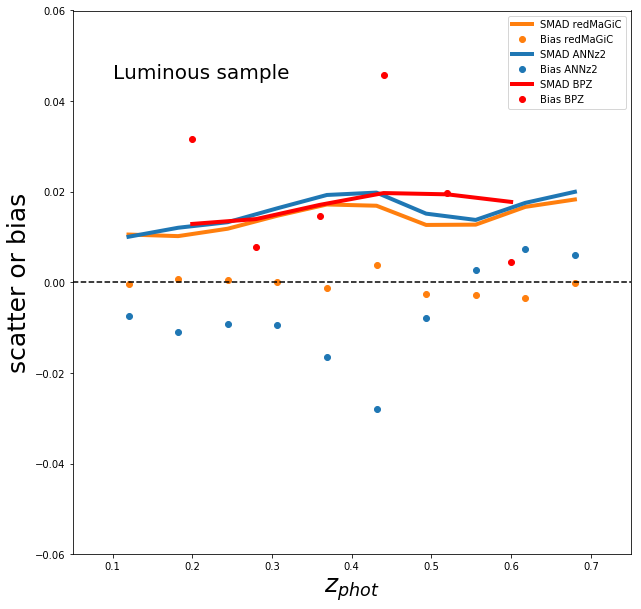

In [34]:
red_bias_scatter_lum()

In [35]:
def red_bias_scatter_lum():
    plt.figure(figsize = (10,10))
    nbins = 10
    bins = np.linspace(0.12 , 0.68 , nbins)
    delta = bins[1]-bins[0]
    
    
    
    mask_one = np.where((np.in1d(ID_lum, ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_lum[mask_one])==True))[0]
    arg_one = np.argsort(ID_lum[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    
    y2 = (z_lum[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_lum[mask_one][arg_one])
    z2 = z_lum[mask_one][arg_one] - z_specall[mask_two][arg_two]
    x2 = z_lum[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    ID_lum_copy = ID_lum[mask_one][arg_one]
    z_spec_matched_to_lum = z_specall[mask_two][arg_two]
    
    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]

    
    plt.plot(bins , running_mad2 , lw = 4, color = '#FF7F0E', label = "mad redMaGiC")
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", color = '#FF7F0E', label = "bias redMaGiC")
    
    
    mask_one = np.where((np.in1d(ID_kids, ID_lum_copy)==True))[0]
    mask_two = np.where((np.in1d(ID_lum_copy,ID_kids[mask_one])==True))[0]
    arg_one = np.argsort(ID_kids[mask_one])
    arg_two = np.argsort(ID_lum_copy[mask_two])
    
    y2 = (z_ann[mask_one][arg_one] - z_spec_matched_to_lum[mask_two][arg_two])/(1+z_ann[mask_one][arg_one])
    z2 = z_ann[mask_one][arg_one] - z_spec_matched_to_lum[mask_two][arg_two]
    x2 = z_ann[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)
    
    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    
    #plt.plot(bins , running_sigma682 , lw= 4, color = '#1F77B4', label = r"$\sigma_{68}/(1+z)$")
    plt.plot(bins , running_mad2 , lw = 4, color = '#1F77B4', label = "mad ANNz2")
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", color = '#1F77B4', label = "mad ANNz2")
    
    plt.plot(np.linspace(0.0,1.0,200) , 0.0*np.linspace(0.1,0.8,200), "k--")
    plt.xlabel(r"$z_{phot}$" , fontsize= 25)
    plt.ylabel("scatter or bias" , fontsize= 25)
    plt.legend(loc = 'best' , fontsize = 10)
    plt.xlim([0.05,0.75])
    plt.ylim([-0.05,0.05])
    plt.text( 0.2, 0.03, "$L/L_{\star}>1.0$", fontsize = 30)

    
    return None

In [42]:
levels = [0.68, 0.95]
def lum_color_inspec():
    
    mask_one = np.where((np.in1d(ID_lum, ID_spec)==True))[0]
    mask_two = np.where((np.in1d(ID_spec,ID_lum[mask_one])==True))[0]
    arg_one = np.argsort(ID_lum[mask_one])
    arg_two = np.argsort(ID_spec[mask_two])
    
    x = colors_lum#[mask_one][arg_one]
    y = colors_spec[mask_two][arg_two]
    
    plt.figure(figsize=(10,10))
    thick_line1 = mlines.Line2D([], [], ls='-', c='#1F77B4', linewidth=12, alpha=0.5, 
                                label="luminous sample with spec-z")
    thick_line2 = mlines.Line2D([], [], ls='-', c='#FF7F0E', linewidth=12, alpha=0.5, 
                                label="luminous sample")
    for i in range (1,12):
        
       mask_all = (z_lum[mask_one][arg_one] <0.12+i*0.05)&(z_lum[mask_one][arg_one] >0.1+i*0.05)
       mask_lum = (z_lum<0.12+i*0.05)&(z_lum>0.1+i*0.05)
       
       print 0.11+i*0.05
       corner.hist2d(x[mask_lum,1] , x[mask_lum,2], color='#FF7F0E', plot_datapoints=False,
                 bins=30, levels=levels, fill_contours=True, smooth=5.0, label = "luminous sample with spec-z")
       corner.hist2d(y[mask_all,1] , y[mask_all,2], color='#1F77B4',plot_datapoints=False,
                 bins=30, levels=levels, fill_contours=True, smooth=5.0, label = "luminous sample")
    
    plt.legend(loc='upper left', handles=[thick_line2, thick_line1], 
               frameon=False, fontsize=15, handletextpad=1.0, scatteryoffsets=[0.5])
    plt.xlim((1,2.2))
    plt.ylim(0.2,1.5)
    plt.xlabel("$g-r$" , fontsize = 20)
    plt.ylabel("$r-i$" , fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)

    return None

0.16
0.21
0.26
0.31
0.36
0.41
0.46
0.51
0.56
0.61
0.66


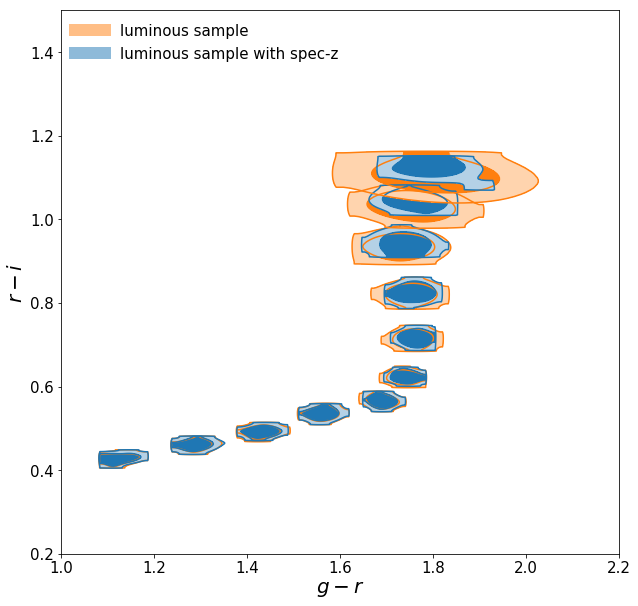

In [43]:
lum_color_inspec()

In [44]:
levels = [0.68, 0.95]
def lum_color_inspec2():
    
    mask_one = np.where((np.in1d(ID_lum, ID_spec)==True))[0]
    mask_two = np.where((np.in1d(ID_spec,ID_lum[mask_one])==True))[0]
    arg_one = np.argsort(ID_lum[mask_one])
    arg_two = np.argsort(ID_spec[mask_two])
    
    x = colors_lum#[mask_one][arg_one]
    y = colors_spec[mask_two][arg_two]
    
    plt.figure(figsize=(10,10))
    
    thick_line1 = mlines.Line2D([], [], ls='-', c='#1F77B4', linewidth=12, alpha=0.5, 
                                label="luminous sample with spec-z")
    thick_line2 = mlines.Line2D([], [], ls='-', c='#FF7F0E', linewidth=12, alpha=0.5, 
                                label="luminous sample")
    for i in range (1,12):
        
       mask_all = (z_lum[mask_one][arg_one] <0.12+i*0.05)&(z_lum[mask_one][arg_one] >0.1+i*0.05)
       mask_lum = (z_lum<0.12+i*0.05)&(z_lum>0.1+i*0.05)&(mi_lum<np.max(mi_spec[mask_two][arg_two][mask_all]))
       
       print 0.11+i*0.05
       corner.hist2d(x[mask_lum,1] , x[mask_lum,2], color='#FF7F0E', plot_datapoints=False,
                 bins=30, levels=levels, fill_contours=True, smooth=5.0, label = "luminous sample with spec-z")
       corner.hist2d(y[mask_all,1] , y[mask_all,2], color='#1F77B4',plot_datapoints=False,
                 bins=30, levels=levels, fill_contours=True, smooth=5.0, label = "luminous sample")
    
    plt.legend(loc='upper left', handles=[thick_line2, thick_line1], 
               frameon=False, fontsize=15, handletextpad=1.0, scatteryoffsets=[0.5])
    plt.xlim((1,2.2))
    plt.ylim(0.2,1.5)
    plt.xlabel("$g-r$" , fontsize = 20)
    plt.ylabel("$r-i$" , fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)

    return None

0.16
0.21
0.26
0.31
0.36
0.41
0.46
0.51
0.56
0.61
0.66


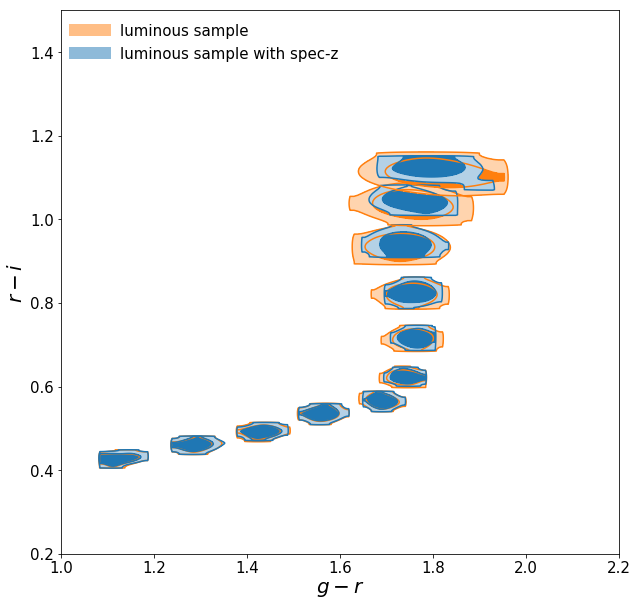

In [45]:
lum_color_inspec2()

In [52]:
levels = [0.68, 0.95]
def dense_color_inspec():
    
    mask_one = np.where((np.in1d(ID_dense, ID_spec)==True))[0]
    mask_two = np.where((np.in1d(ID_spec,ID_dense[mask_one])==True))[0]
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_spec[mask_two])
    
    x = colors_dense#[mask_one][arg_one]
    y = colors_spec[mask_two][arg_two]
    
    plt.figure(figsize=(10,10))
    
    thick_line1 = mlines.Line2D([], [], ls='-', c='#1F77B4', linewidth=12, alpha=0.5, 
                                label="dense sample with spec-z")
    thick_line2 = mlines.Line2D([], [], ls='-', c='#FF7F0E', linewidth=12, alpha=0.5, 
                                label="dense sample")
    for i in range (1,12):
        
       mask_all = (z_dense[mask_one][arg_one] <0.12+i*0.05)&(z_dense[mask_one][arg_one] >0.1+i*0.05)
       mask_lum = (z_dense<0.12+i*0.05)&(z_dense>0.1+i*0.05)
       
       print 0.11+i*0.05
       corner.hist2d(x[mask_lum,1] , x[mask_lum,2], color='#FF7F0E', plot_datapoints=False,
                 bins=50, levels=levels, fill_contours=True, smooth=4.0, label = "luminous sample with spec-z")
       corner.hist2d(y[mask_all,1] , y[mask_all,2], color='#1F77B4',plot_datapoints=False,
                 bins=50, levels=levels, fill_contours=True, smooth=4.0, label = "luminous sample")
    
    plt.legend(loc='upper left', handles=[thick_line2, thick_line1], 
               frameon=False, fontsize=15, handletextpad=1.0, scatteryoffsets=[0.5])
    plt.xlim((1,2.2))
    plt.ylim(0.2,1.5)
    plt.xlabel("$g-r$" , fontsize = 20)
    plt.ylabel("$r-i$" , fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)

    return None

0.16
0.21
0.26
0.31
0.36
0.41
0.46
0.51
0.56
0.61
0.66


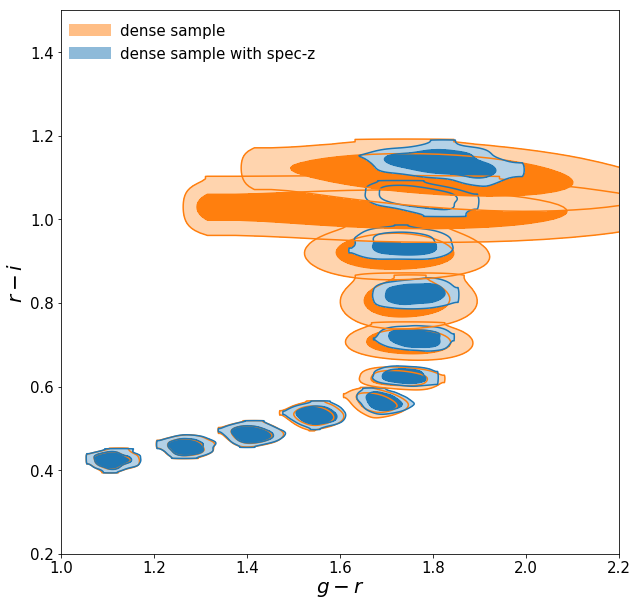

In [53]:
dense_color_inspec()

In [50]:
levels = [0.68, 0.95]
def dense_color_inspec2():
    
    mask_one = np.where((np.in1d(ID_dense, ID_spec)==True))[0]
    mask_two = np.where((np.in1d(ID_spec,ID_dense[mask_one])==True))[0]
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_spec[mask_two])
    
    x = colors_dense#[mask_one][arg_one]
    y = colors_spec[mask_two][arg_two]
    
    plt.figure(figsize=(10,10))
    
    thick_line1 = mlines.Line2D([], [], ls='-', c='#1F77B4', linewidth=12, alpha=0.5, 
                                label="dense sample with spec-z")
    thick_line2 = mlines.Line2D([], [], ls='-', c='#FF7F0E', linewidth=12, alpha=0.5, 
                                label="dense sample")
    for i in range (1,12):
        
       mask_all = (z_dense[mask_one][arg_one] <0.12+i*0.05)&(z_dense[mask_one][arg_one] >0.1+i*0.05)
       mask_lum = (z_dense<0.12+i*0.05)&(z_dense>0.1+i*0.05)&(mi_dense<np.max(mi_spec[mask_two][arg_two][mask_all]))
       
       print 0.11+i*0.05
       corner.hist2d(x[mask_lum,1] , x[mask_lum,2], color='#FF7F0E', plot_datapoints=False,
                 bins=60, levels=levels, fill_contours=True, smooth=4.0, label = "luminous sample with spec-z")
       corner.hist2d(y[mask_all,1] , y[mask_all,2], color='#1F77B4',plot_datapoints=False,
                 bins=60, levels=levels, fill_contours=True, smooth=4.0, label = "luminous sample")
    
    plt.legend(loc='upper left', handles=[thick_line2, thick_line1], 
               frameon=False, fontsize=15, handletextpad=1.0, scatteryoffsets=[0.5])
    plt.xlim((1,2.2))
    plt.ylim(0.2,1.5)
    plt.xlabel("$g-r$" , fontsize = 20)
    plt.ylabel("$r-i$" , fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)

    return None

0.16
0.21
0.26
0.31
0.36
0.41
0.46
0.51
0.56
0.61
0.66


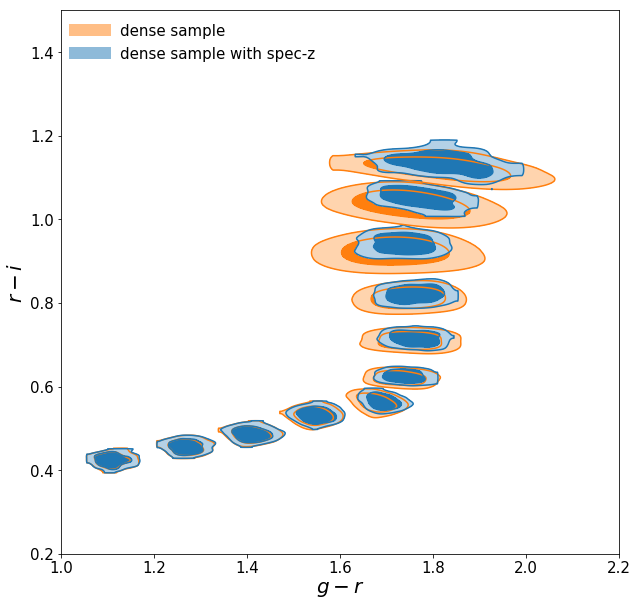

In [51]:
dense_color_inspec2()